In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
import pandas as pd
import matplotlib.pylab as pylab
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score
from operator import itemgetter
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


pylab.rcParams['figure.figsize'] = 5, 5
plt.rc("font", size=15)


plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

In this notebook we are going to learn what a **decision tree** is, how it does classification and what the **hyperparameters** used to define it actually do and stand for.

Then we are going to superficially describe how decision trees are basic bricks of more powerful algorithms called **ensemble algorithms**. You will see that these algorithm can be quite diverse. Since they are quite useful and commonly used I will spend some time showing how different they actually are from one another and what that means. 

# Decision tree based classification

## Table Of Content:

* [Decision Tree](#Decision-Tree)


* [Random Forest](#Random-Forest)


* [Ada Boost](#Ada-Boost)


* [Boosted Gradient](#Boosted-Gradient)


* [Exercise](#exo)

In [2]:
# Multiclassification dataset

iris = load_iris()

df_iris = pd.concat([pd.DataFrame(iris['data'],columns=iris['feature_names']),\
                       pd.DataFrame(iris['target'],columns=['species'])],axis=1)


(X_iris, y_iris) = load_iris(return_X_y = True)



#Classification dataset

cancer = load_breast_cancer()
df_cancer = pd.concat([pd.DataFrame(cancer['data'],columns=cancer['feature_names']),\
                       pd.DataFrame(cancer['target'],columns=['malignant'])],axis=1)

(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)


In [3]:

X_cancer_train, X_cancer_test, y_cancer_train, y_cancer_test = train_test_split(X_cancer, y_cancer,
                                                   random_state=7, stratify=y_cancer)

X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(X_iris, y_iris,
                                                   random_state=1, stratify=y_iris)

# Decision tree <a class="anchor" id="Decision-Tree"></a>

In [4]:
#only for graphical representation of the trees : you don't need it for analysis.
#you will need to pip install pydotplus the first time so just remove the # sign
#!pip install pydotplus
#You will need graphviz lib also. Download it here : https://graphviz.gitlab.io/download/
#You will need to add it to your python path
import os
os.environ["PATH"] += os.pathsep + 'C:/graphviz-2.38/release/bin/'#path where you installed it

**A simple decision tree reduces your problem into a hierarchichal sequence of questions on your features that can be answered by yes or no and that subdivides the data into 2 subgroups on which a new question is asked, and so on and so on.**

![tree_ex](../images/tree_ex.png)

Ok, but a huge number of trees can actually be built just by considering the different orders of questions asked. How does the algorithm deals with this?

Quite simply actually. **It tests all the features and chooses the most discriminative (in terms of your labels) : the feature where a yes or no question divides the data into 2 subsets which minimizes an impurity measure.** 

**The impurity is related to how much your feature splitting is still having mixed classes**. Note that impurity then goes through a function to give a score: either it is a simple Shannon entropy or it is a Gini entropy.

Imagine you have a dataset with feature color (red or blue) and feature shape (square or circle), and 2 classes (1,2):

If answering `True` to "feature color is red" gives you a subgroup of 10 class 1, and 1 class 2 and, `False` gives you 2 class 1, and 11 class 2 then it is a better classifier than:

"feature shape is square" that gives you a subgroup of 5 class 1, and 7 class 2 on one hand, and 7 class 1 and 5 class 2 on the other hand.

![tree](../images/Tree.png)

**The points are better separated in terms of their classes by answering True or False for feature color than for feature shape.** Some of you could already see that entropy calculation could be a good way to summarize all that text above, hence my little aparte about impurity before.

**This is something "easy" to visualize if your features are categorical like 'yellow' but if they are numeric features like weights, how do you transform that to a yes/no questions? By choosing a threshold...** But how do you choose the threshold? Again choose threshold which minimize impurity. When you have a threshold for each feature then you can compare their impurities. You will have to compute this threshold at each step of your tree since at each step you are considering different subdatasets.


Before going further, just a little bit of vocabulary: 
* **Trees** are made of **nodes** (where the question is asked and where the splitting occurs). 
* A **branch** is the outcome of a splitting. 
* A **leaf** is the last node on a branch (no more splitting).

### Toy data : exploring hyperparameters


Let explore some hyperparameters of this method that, you will see in those examples, act like a regularization:
- **Max Tree depth**: the maximum number of consecutive questions to ask
- **Min Splitting of nodes**: the minimum number of point that should be considered to make a new rule, outside of the leaves
- **Min Splitting of leaves**: the minimum number of point that should be considered to make a new rule at the leaves

In [6]:
from sklearn.datasets import make_blobs

X_3, y_3 = make_blobs(n_samples=120, centers=3,cluster_std=[[1,3],[1,3],[1,3]], random_state=6)


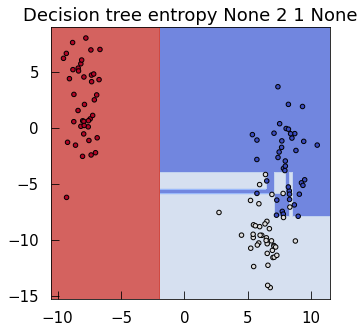

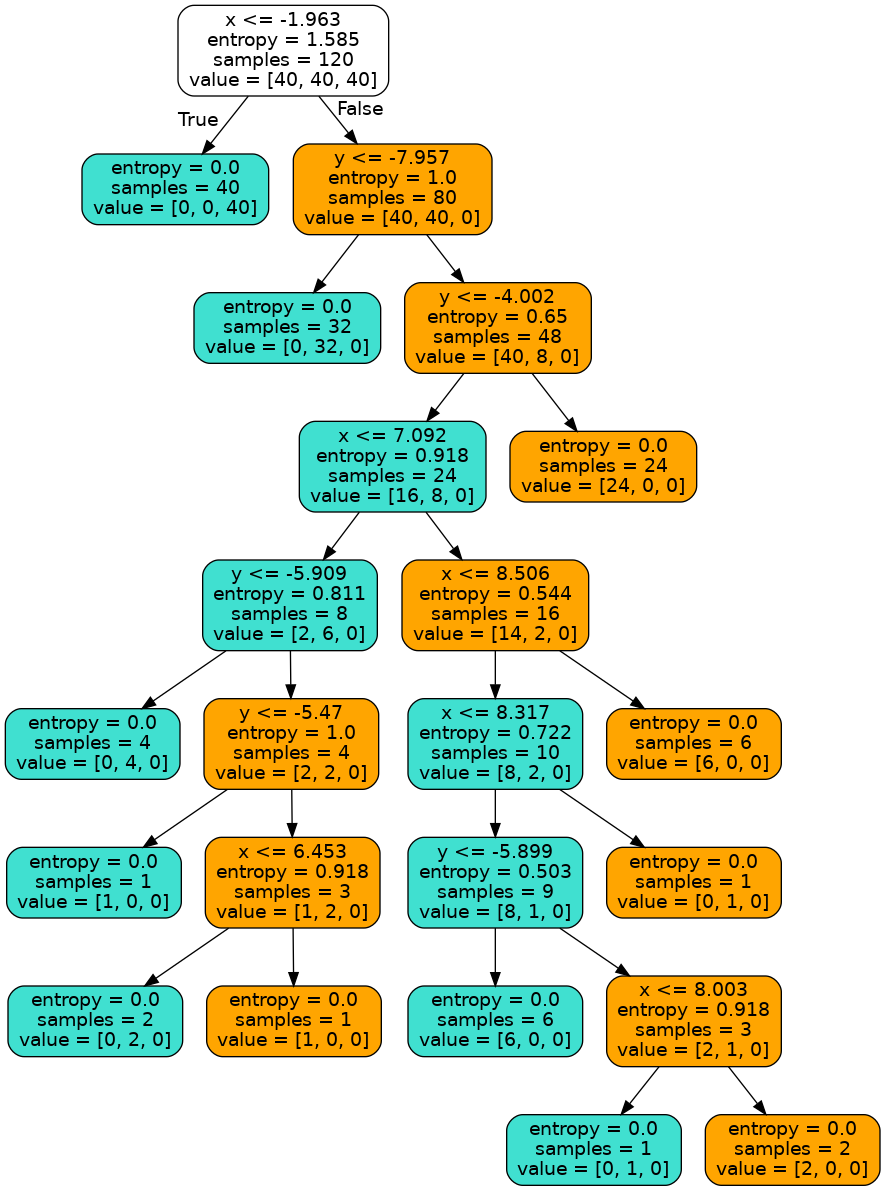

In [7]:
from utils import countour_tree

countour_tree(X_3, y_3,
              crit = 'entropy',
              maxd = None,
              min_s = 2,
              min_l = 1,
              max_f = None)
#You can see that there are 5 hyperparameters here. Let's see what they do and what they mean.
#I bet you can already guess it is going to be related to regularization....
# After X,y you have 
# * crit = 'entropy' which is one way to calculate impurity (you could also put gini here)
# * maxd : the max depth of your tree
# * min_s : the number of points that should be concerned by the making of a new rule (splitting of the nodes)
# * min_l : #of points that should be considered to make a final leaf classification
# * max_f maximum number of features to consider for making a new rule...

Well that's a really complicated and zealous tree. Look at those boundaries. Clearly if we just let it go like that it is overfitting...

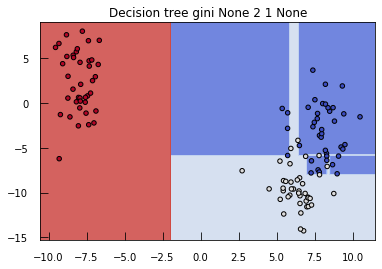

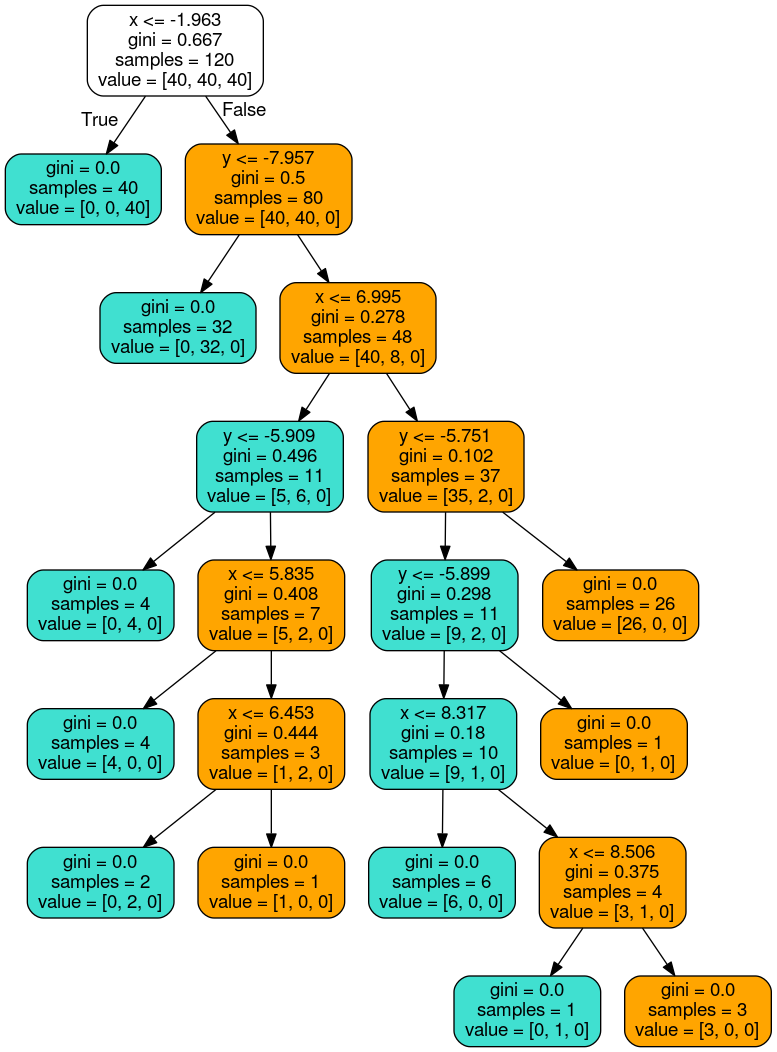

In [8]:
#using another impurity measurement
countour_tree(X_3, y_3,
              crit = 'gini',
              maxd = None,
              min_s = 2,
              min_l = 1,
              max_f = None)

Still some overfitting but it is nice to see that the boundaries are different and that impurity calculations, even if very similar, are making a difference.

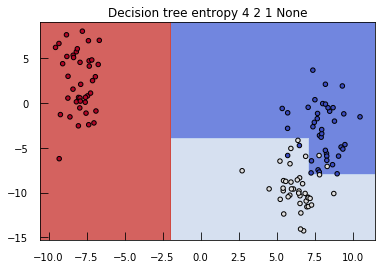

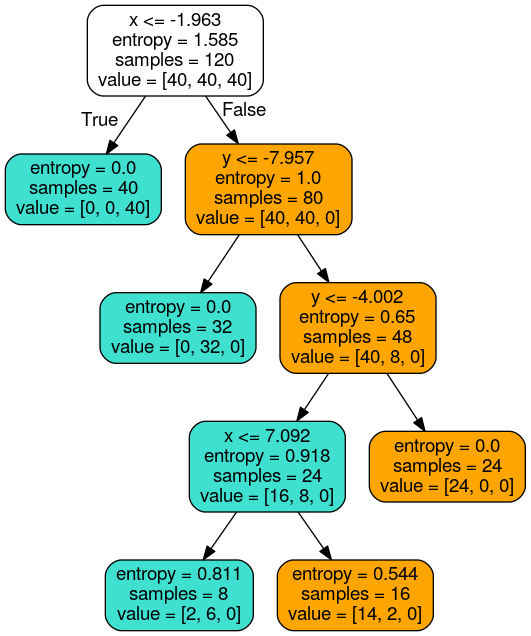

In [9]:
#Imposing a limit for the depth of the tree : how many questions you ask (here set to 4)
countour_tree(X_3, y_3,
              crit = 'entropy',
              maxd = 4,
              min_s = 2, min_l = 1, max_f = None)

Indeed only a maximum of 4 splitting events link the root to the leafs.

Here you stopped the tree at some points allowing some misslabelling instead of fitting perfectly the dataset.

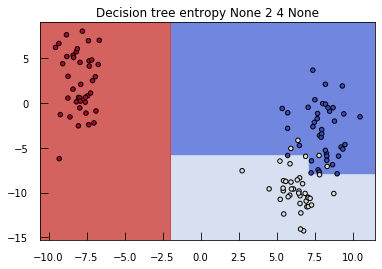

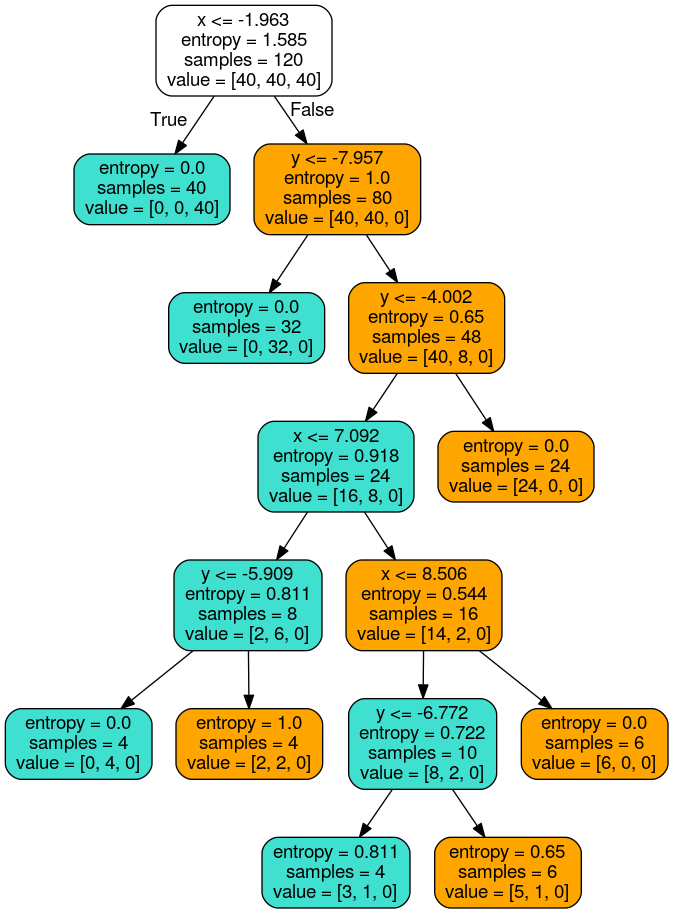

In [10]:
countour_tree(X_3, y_3,
              crit = 'entropy',
              maxd = None,
              min_s = 2,
              min_l = 4,
              max_f = None)
# I don't really have a feeling of where I should stop the tree depth. 
# But I have an understanding of this other parameter (here set to 4) called min_samples_leaf : 
# it sets the minimal number of data points that the overall chain of rules should concern. 
# Do you really wish to create a whole new set of rules to explain only one particular data point? 

Convince yourself that now rules are made for leafs of at least 4 points contrary to trees that we built before and for which you could have leaves containing only 2 points

The tree is simplified and the boundaries look more flexible.

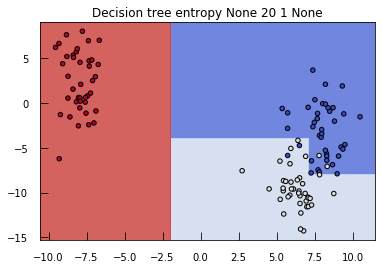

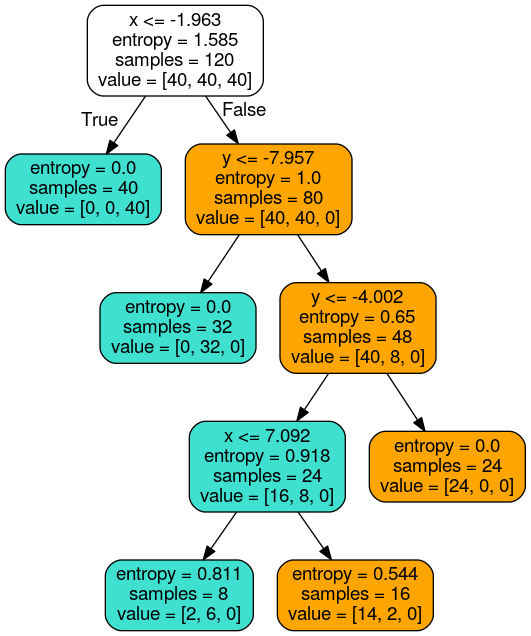

In [11]:
countour_tree(X_3, y_3,
              crit = 'entropy',
              maxd = None,
              min_s = 20,
              min_l = 1,
              max_f = None)
# Here it is the same as before but this time it applies to intermediary splittings instead of the last splitting.
# This parameter is called min_samples_split and is set to 20 here.

Check that indeed there is no node splitting concerning less than 20 points

**The interesting thing with this kind of method is that it works with all types of feature (numerical or class, I mean in theory), you don't need to rescale and it already includes non linear fitting. Moreover it is 'easy' to interpret.** 

But....(yes there is a but, there is no free lunch)

**Even with all of those hyperparamaters they are still not great on new data (inacuracy....).** We will see that in the real data example below and we will see more powerful technics based on decision tree that are more costly but generalize better.

**To do if you are curious:**

We didn't check how the maximum number of features for making a decision would affect the tree. Try it.

This hyperparameter set the number of randomly picked features to consider at each node splitting. By setting it up at None we consider all the features. But you could also fix that number as you wish or choose a known good scaling for your data which is either square root of the number of features or log2 of the number of features.

N.B. this only affects node splitting : all the features are considered when the tree is built it is just that you randomly pick from the full set at each node splitting event.

### Cancer data set

Now let's check the effects of those parameters on test and train sets accuracy. Are they acting like regularization?

#### Starting with max_depth

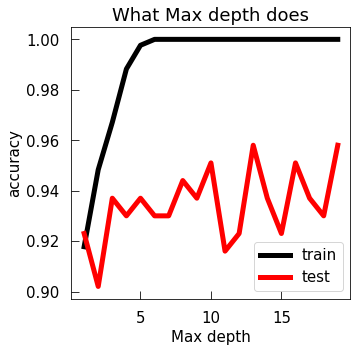

In [8]:
# testing the accuracy of the tree classifier for max depth from 1 to 20
max_dep = range(1,20)
scores_test = []
scores_train = []

for k in max_dep:
    tree = DecisionTreeClassifier(max_depth = k,class_weight='balanced')
    tree.fit(X_cancer_train,y_cancer_train)
    scores_test.append(tree.score(X_cancer_test, y_cancer_test))
    scores_train.append(tree.score(X_cancer_train, y_cancer_train))

# plotting
plt.figure()
plt.xlabel('Max depth')
plt.ylabel('accuracy')
plt.title('What Max depth does')
plt.plot(max_dep, scores_train,'k-',linewidth=5,label='train')
plt.plot(max_dep, scores_test,'r-',linewidth=5,label='test')
#plt.xticks([0,20,40,60,80,100])
plt.legend(loc='best')
plt.show()

Another great case of overfitting the data : too much depth means making more and more logical sets of rules to explain every specificity of points. So Accuracy for train reaches 1 where accuracy for test wiggles and overall goes down.

#### min_samples_splitting

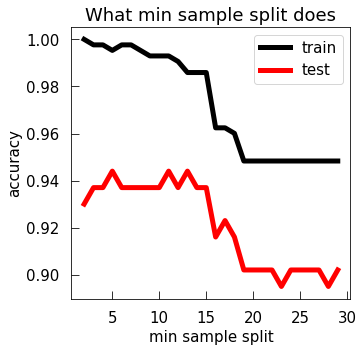

In [9]:
min_samples_spl = range(2,30)
scores_test = []
scores_train = []

for k in min_samples_spl:
    tree = DecisionTreeClassifier(min_samples_split = k,class_weight='balanced')
    tree.fit(X_cancer_train,y_cancer_train)
    scores_test.append(tree.score(X_cancer_test, y_cancer_test))
    scores_train.append(tree.score(X_cancer_train, y_cancer_train))

plt.figure()
plt.xlabel('min sample split')
plt.ylabel('accuracy')
plt.title('What min sample split does')
plt.plot(min_samples_spl, scores_train,'k-',linewidth=5,label='train')
plt.plot(min_samples_spl, scores_test,'r-',linewidth=5,label='test')
#plt.xticks([0,20,40,60,80,100])
plt.legend(loc='best')
plt.show()

Min_sample_split in our case doesn't seem to do much. But overall it is a parameter that constrains on how many samples (how specific) a rule should be applied to be envisaged.

#### min_samples_leaf

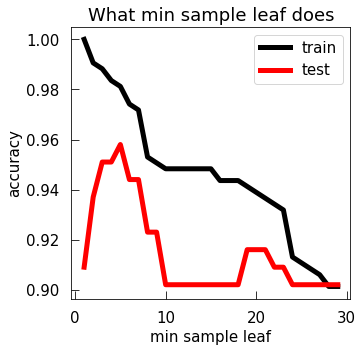

In [10]:
min_samples_lea = range(1,30)
scores_test = []
scores_train = []

for k in min_samples_lea:
    tree = DecisionTreeClassifier(min_samples_leaf = k,class_weight='balanced')
    tree.fit(X_cancer_train,y_cancer_train)
    scores_test.append(tree.score(X_cancer_test, y_cancer_test))
    scores_train.append(tree.score(X_cancer_train, y_cancer_train))

plt.figure()
plt.xlabel('min sample leaf')
plt.ylabel('accuracy')
plt.title('What min sample leaf does')
plt.plot(min_samples_lea, scores_train,'k-',linewidth=5,label='train')
plt.plot(min_samples_lea, scores_test,'r-',linewidth=5,label='test')
#plt.xticks([0,20,40,60,80,100])
plt.legend(loc='best')
plt.show()

How do you interpret this plot?

#### Let's train our model properly

In [11]:
grid_values = {'criterion': ['entropy','gini'],
               'max_depth':np.arange(2,len(X_cancer_train),20),
               'min_samples_split':np.arange(2,len(X_cancer_train),20),
              'min_samples_leaf':np.arange(1,len(X_cancer_train),20)}# define the hyperparameters you want to test
#with the range over which you want it to be tested.

grid_tree_acc = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), param_grid = grid_values, scoring='accuracy',n_jobs=-1)#Feed it to the GridSearchCV with the right
#score over which the decision should be taken

grid_tree_acc.fit(X_cancer_train, y_cancer_train)

y_decision_fn_scores_acc=grid_tree_acc.score(X_cancer_test,y_cancer_test)

print('Grid best parameter (max. accuracy): ', grid_tree_acc.best_params_)#get the best parameters
print('Grid best score (accuracy): ', grid_tree_acc.best_score_)#get the best score calculated from the train/validation
#dataset
print('Grid best parameter (max. accuracy) model on test: ', y_decision_fn_scores_acc)# get the equivalent score on the test
#dataset : again this is the important metric

y_pred_test_c=grid_tree_acc.predict(X_cancer_test)

confusion_mc_c = confusion_matrix(y_cancer_test, y_pred_test_c)
df_cm_c = pd.DataFrame(confusion_mc_c, 
                     index = [i for i in range(0,len(cancer['target_names']))], columns = [i for i in range(0,len(cancer['target_names']))])

Grid best parameter (max. accuracy):  {'criterion': 'entropy', 'max_depth': 222, 'min_samples_leaf': 1, 'min_samples_split': 2}
Grid best score (accuracy):  0.9601094391244871
Grid best parameter (max. accuracy) model on test:  0.9440559440559441


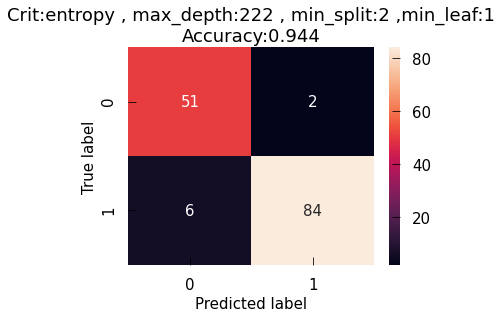

In [12]:
plt.figure(figsize=(5.5,4))
ax = sns.heatmap(df_cm_c, annot=True)
ax.set_ylim(2, 0)
ax.set_title('Crit:'+str(grid_tree_acc.best_params_['criterion'])
          +' , max_depth:'+str(grid_tree_acc.best_params_['max_depth'])+' , min_split:'+str(grid_tree_acc.best_params_['min_samples_split'])+
          ' ,min_leaf:'+str(grid_tree_acc.best_params_['min_samples_leaf'])
          +'\nAccuracy:{0:.3f}'.format(accuracy_score(y_cancer_test, 
                                                                       y_pred_test_c)))
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()

That's a very complicated tree..... And not performing as well as you would expect from something so complicated....

To get the importance of features associated to it just follow this code. You will have to retrain your model with the hyperparameters found in GridSearchCV. Indeed the direct outcome of GridSearchCV doesn't allow the usage of feature_importances...

In [13]:

tree = DecisionTreeClassifier(criterion=grid_tree_acc.best_params_['criterion'],
                             max_depth=grid_tree_acc.best_params_['max_depth'],
                             min_samples_leaf=grid_tree_acc.best_params_['min_samples_leaf'],
                             min_samples_split=grid_tree_acc.best_params_['min_samples_split'],class_weight='balanced')
tree.fit(X_cancer_train, y_cancer_train)
w=tree.feature_importances_#get the weights

sorted_features=sorted([[cancer['feature_names'][i],abs(w[i])] for i in range(len(w))],key=itemgetter(1),reverse=True)

print('Features sorted per importance in discriminative process')
soted_feature_df=pd.DataFrame(sorted_features,columns=['feature','abs contribution to the model'])
soted_feature_df

Features sorted per importance in discriminative process


,feature,abs contribution to the model
0,worst perimeter,6.799035e-01
1,worst concave points,1.055397e-01
2,worst texture,6.867140e-02
3,mean smoothness,3.373176e-02
4,radius error,2.799923e-02
5,worst symmetry,1.611545e-02
6,symmetry error,1.576870e-02
7,worst compactness,1.248931e-02
8,worst area,1.151855e-02
9,worst fractal dimension,1.151855e-02


###  Exo Iris data set

Train the best decision tree possible for classifying irises species

Grid best parameter (max. accuracy):  {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2}
Grid best score (accuracy):  0.9470355731225297
Grid best parameter (max. accuracy) model on test:  0.9736842105263158


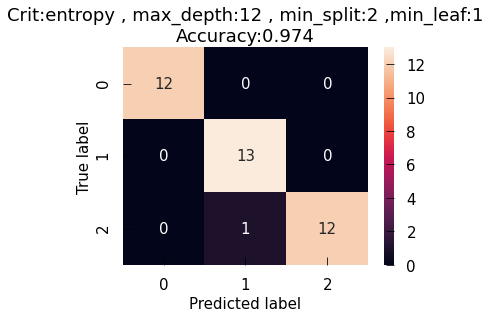

In [14]:
grid_values = {'criterion': ['entropy','gini'],
               'max_depth':np.arange(2,len(X_iris_train),10),
               'min_samples_split':np.arange(2,len(X_iris_train),10),
              'min_samples_leaf':np.arange(1,len(X_iris_train),10)}# define the hyperparameters you want to test
#with the range over which you want it to be tested.

grid_tree_acc = GridSearchCV(DecisionTreeClassifier(), param_grid = grid_values, scoring='accuracy',n_jobs=-1)#Feed it to the GridSearchCV with the right
#score over which the decision should be taken

grid_tree_acc.fit(X_iris_train, y_iris_train)

y_decision_fn_scores_acc=grid_tree_acc.score(X_iris_test,y_iris_test)

print('Grid best parameter (max. accuracy): ', grid_tree_acc.best_params_)#get the best parameters
print('Grid best score (accuracy): ', grid_tree_acc.best_score_)#get the best score calculated from the train/validation
#dataset
print('Grid best parameter (max. accuracy) model on test: ', y_decision_fn_scores_acc)# get the equivalent score on the test
#dataset : again this is the important metric

y_pred_test_i=grid_tree_acc.predict(X_iris_test)

confusion_mc_i = confusion_matrix(y_iris_test, y_pred_test_i)
df_cm_i = pd.DataFrame(confusion_mc_i, 
                     index = [i for i in range(0,len(iris['target_names']))], 
                       columns = [i for i in range(0,len(iris['target_names']))])

plt.figure(figsize=(5.5,4))
ax = sns.heatmap(df_cm_i, annot=True)
ax.set_ylim(3,0)
plt.title('Crit:'+str(grid_tree_acc.best_params_['criterion'])
          +' , max_depth:'+str(grid_tree_acc.best_params_['max_depth'])+' , min_split:'+str(grid_tree_acc.best_params_['min_samples_split'])+
          ' ,min_leaf:'+str(grid_tree_acc.best_params_['min_samples_leaf'])
          +'\nAccuracy:{0:.3f}'.format(accuracy_score(y_iris_test, 
                                                                       y_pred_test_i)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Random Forest <a class="anchor" id="Random-Forest"></a>

**the Random Forest algorithm relies on two main concepts : producing/training many trees all different from an element of randomness, and then asking all the trees what their prediction on new points is and choose a way to agglomerate those different predictions (mainly averaging).** 

Those elements of randomness concern the **bootstrapping of the training dataset** and also only using a **random subset of features for creating the trees in the forest** (this is different from setting a max_feature this time!). Each  bootstrap replicate is going to be used to **train a new tree in the forest** (and this tree will be build only with the randomly drawn subset of parameters).

**Bootstrapping methods are sampling methods in which you randomly draw a subsample from your data**. You keep the same size as the initial data though, which is possible because duplicates of points are allowed (ie. you sample with replacement). This bootstrap replicate is used to train a single tree, with only a subsample of the features. 

I am sure you can see intuitively how that is going to help generalization of our model.

So now on top of all the parameters seen before to create each individual trees of the forest, you also have a parameter controlling the number of trees in your forest.


**In the following plots I am plotting the result for a random forest algorithm and compare it to a single decision tree sharing the same hyperparameters value than the one used in the random forest**.


![RF](../images/RF.png)

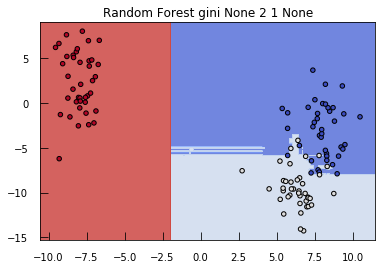

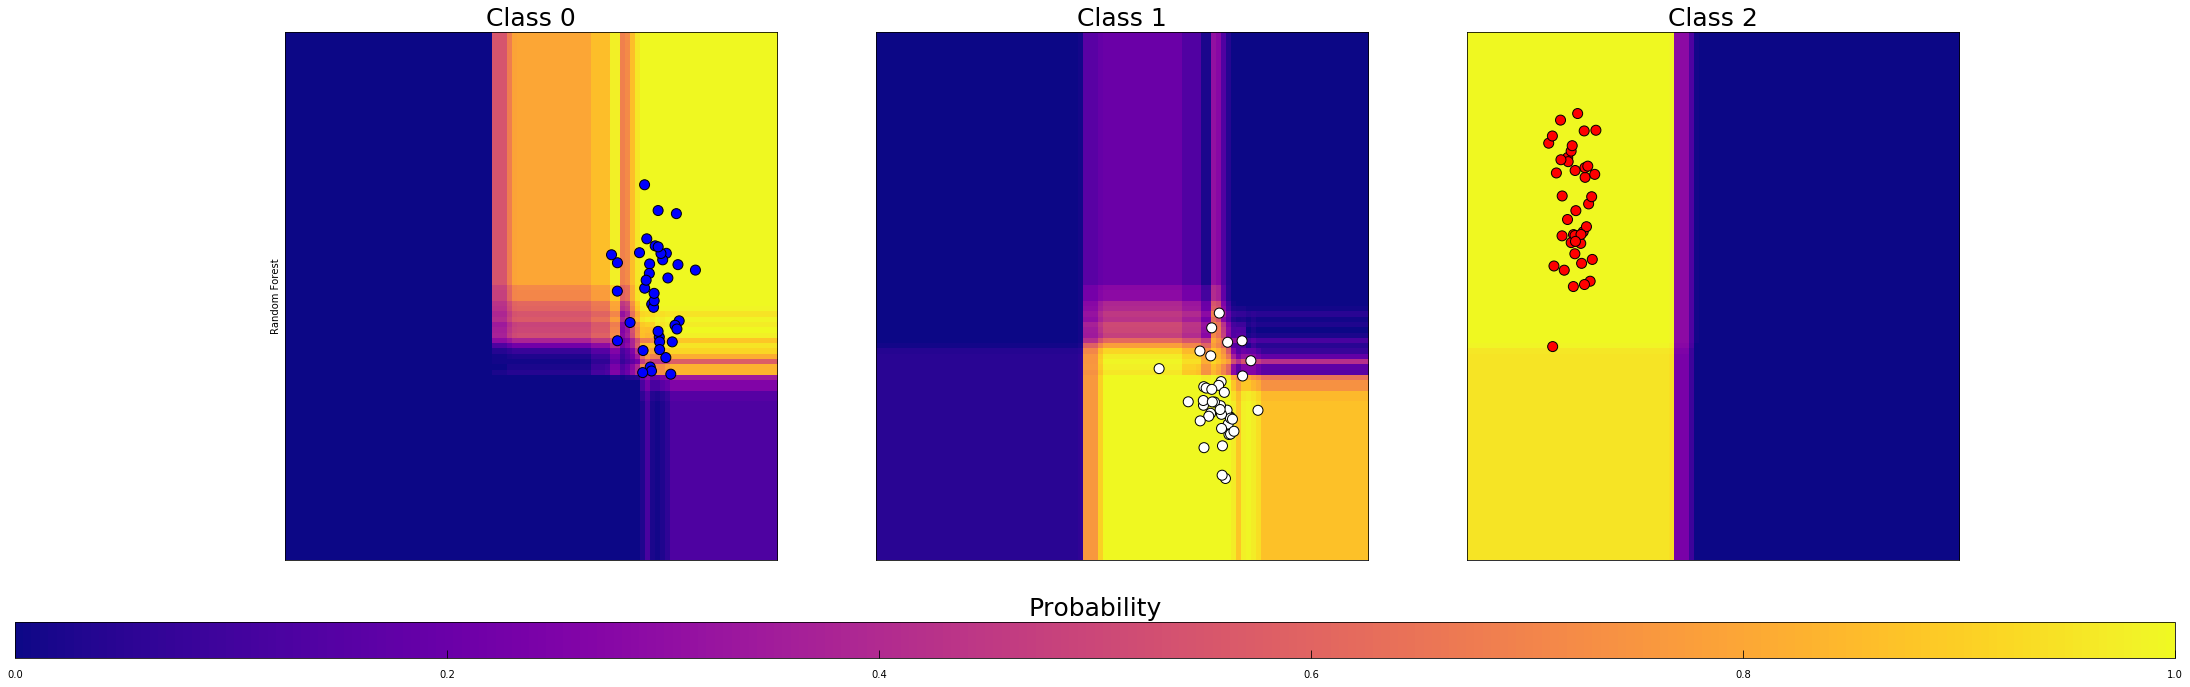

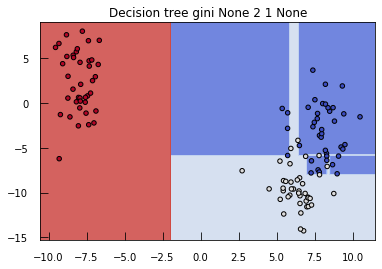

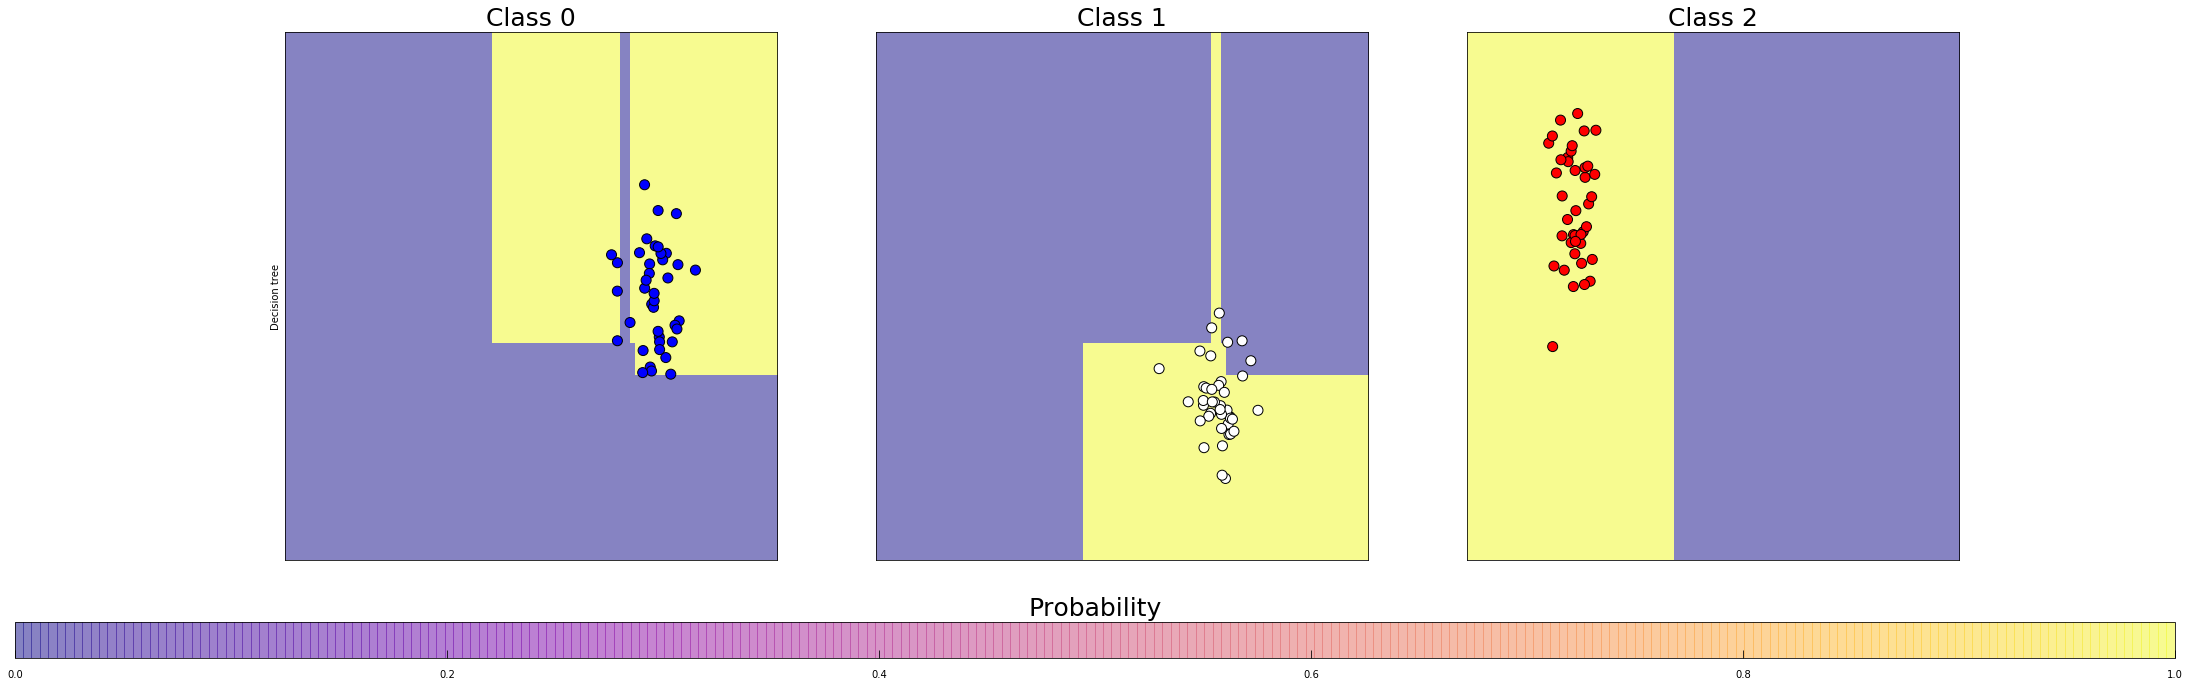

In [20]:
from utils import countour_RF
countour_RF(X_3, y_3,
            n_tree = 100,
            crit = 'gini',
            maxd = None,
            min_s = 2,
            min_l = 1,
            max_f = None)
#Same as for decision tree except that we have here one more hyperparameter, 
# here put to 100 and that represents the number of bootstraps 
# (number of trees trained and then participating to the vote)

See how in the case of random forest the iso-probability lines are less binary than in the case of the decision tree? 

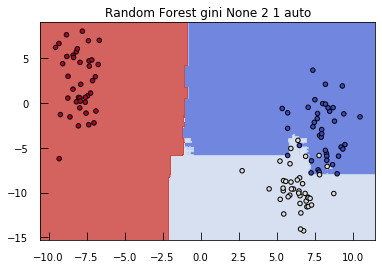

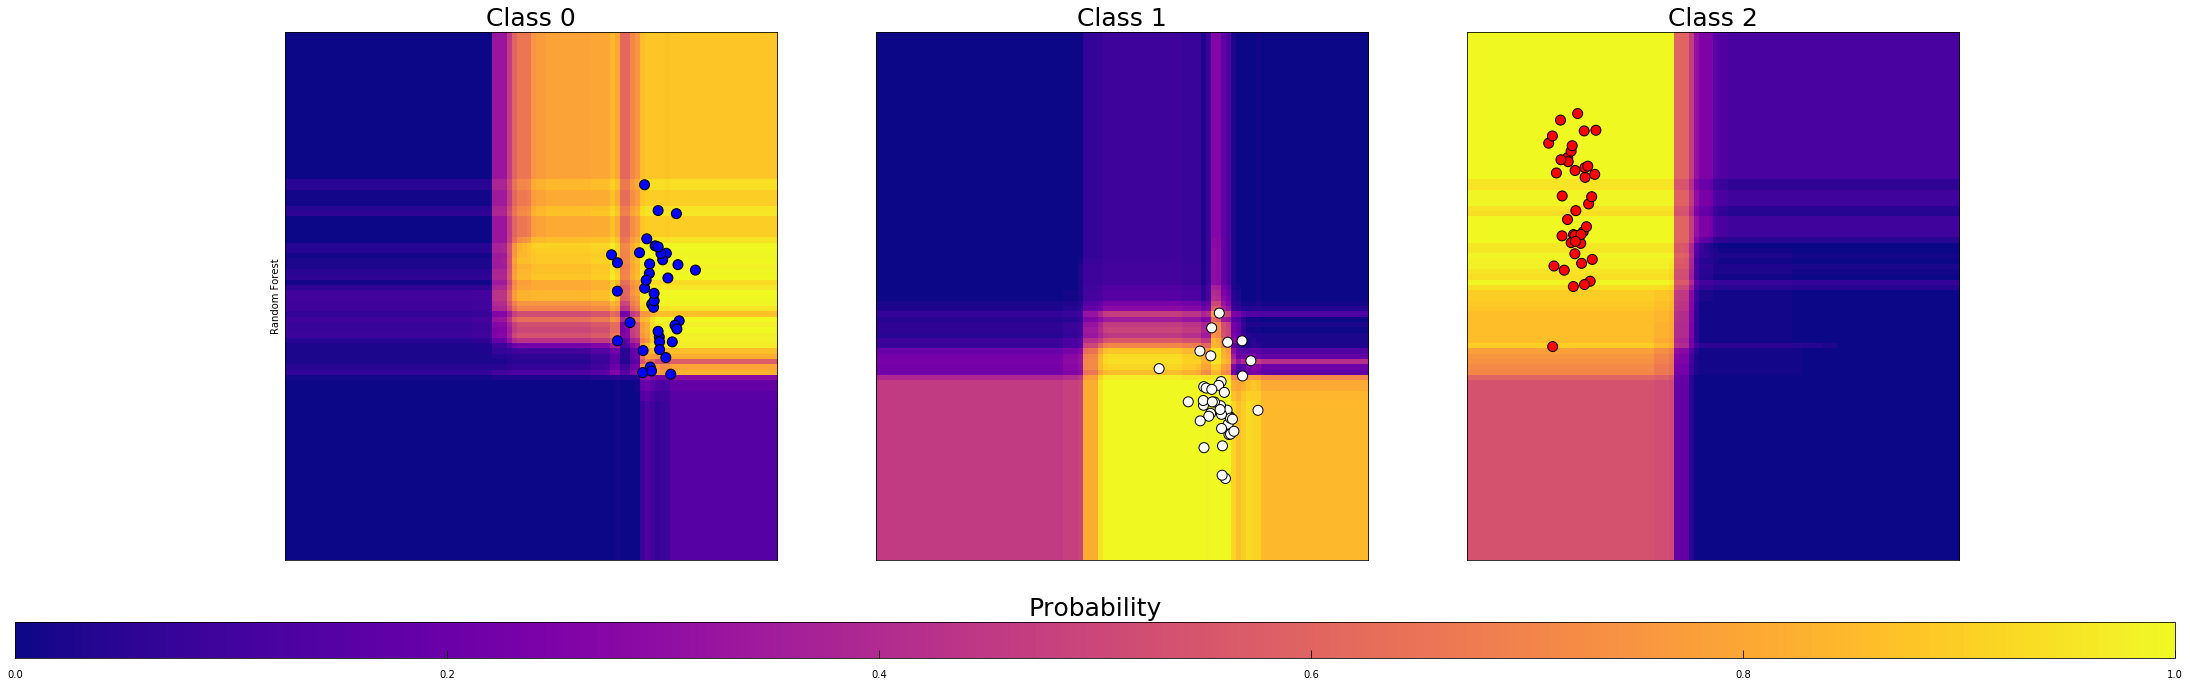

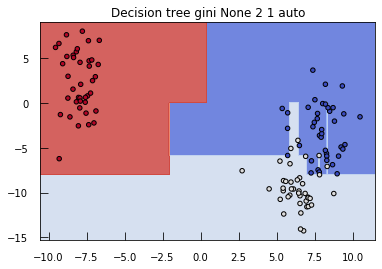

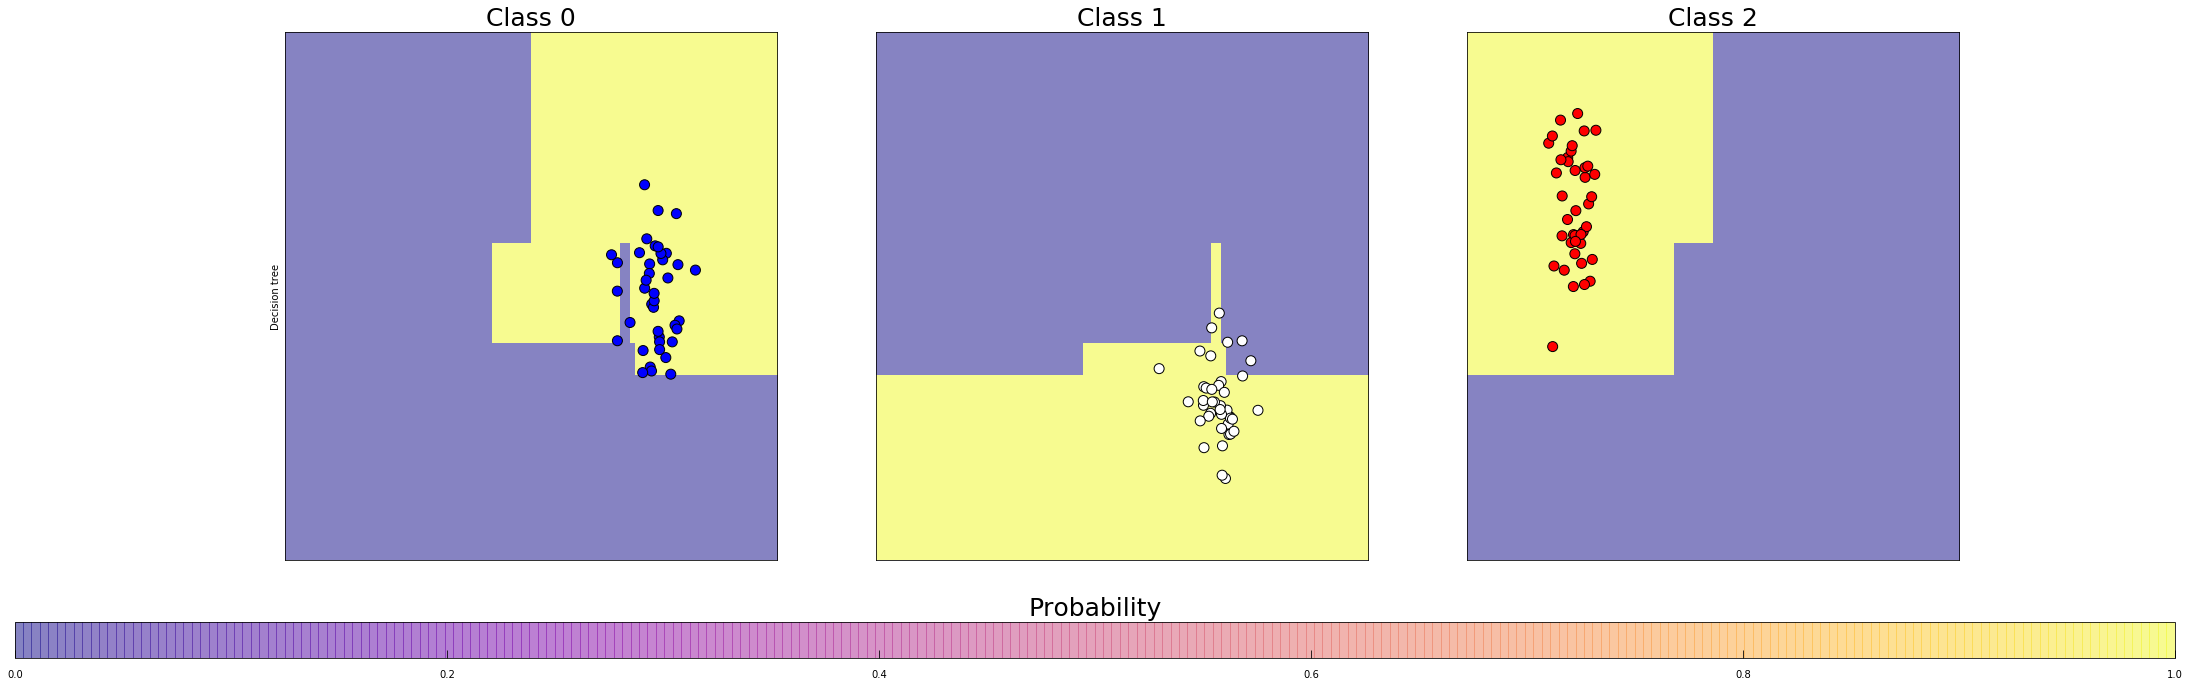

In [21]:
countour_RF(X_3, y_3,
            n_tree = 100, crit = 'gini',maxd = None, min_s = 2, min_l = 1,
            max_f = 'auto')
# The difference here is that we set the max number of feature to split node to auto 
# (square root of the total number of features). 
#Before with None we were considering all the feature for node splitting.

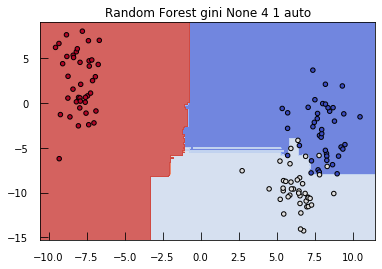

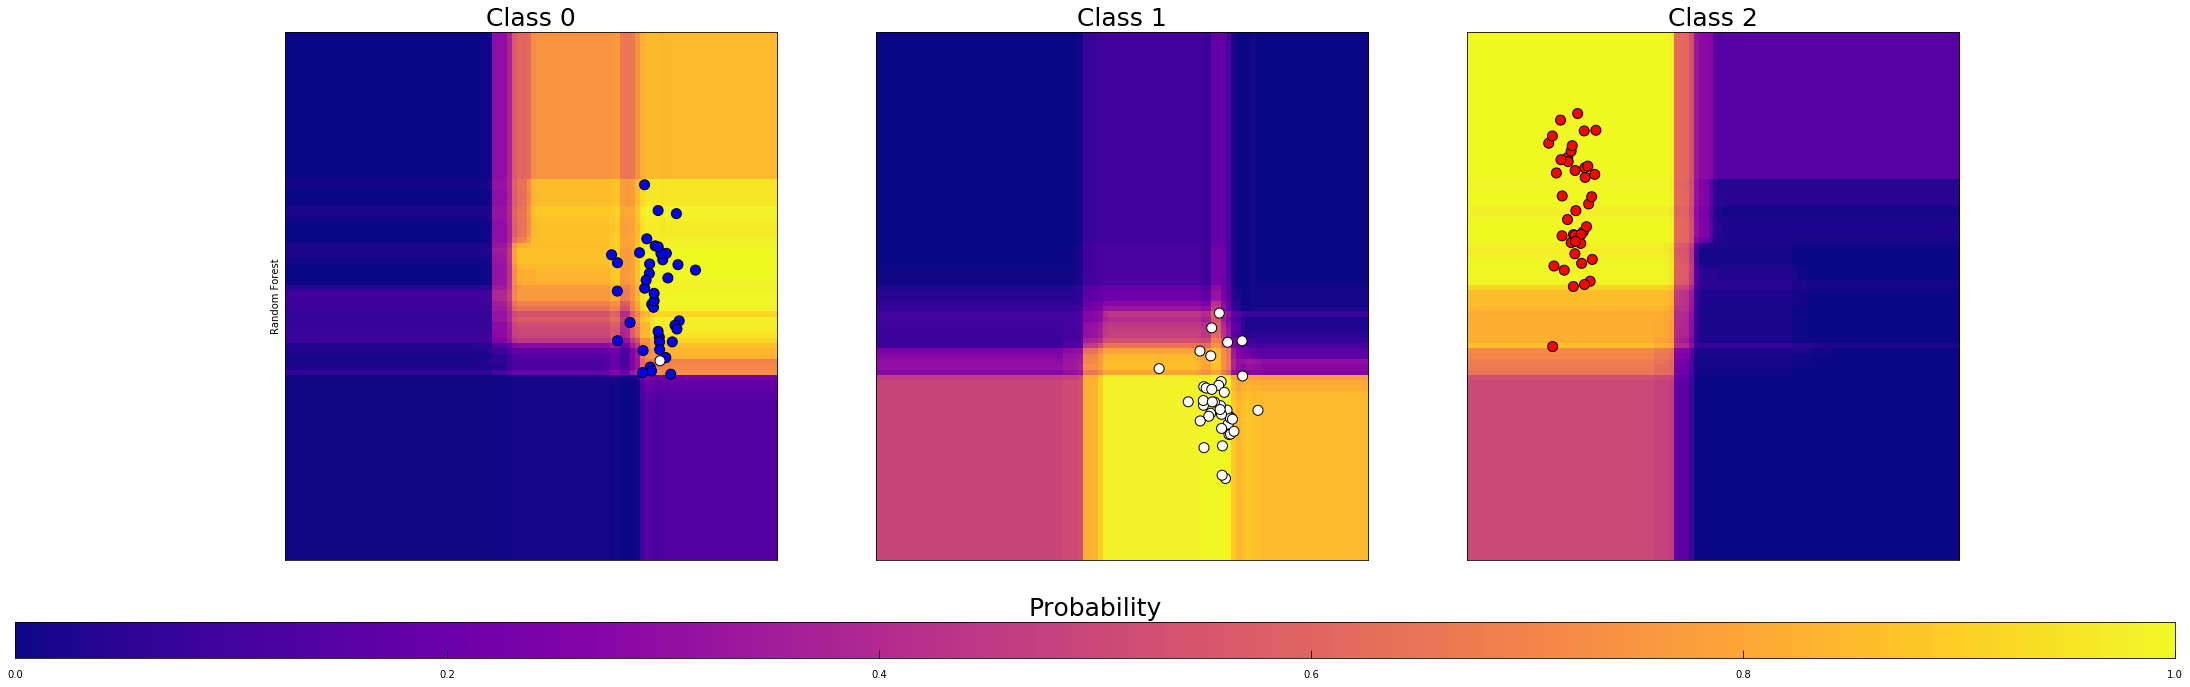

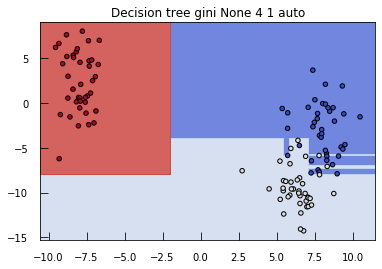

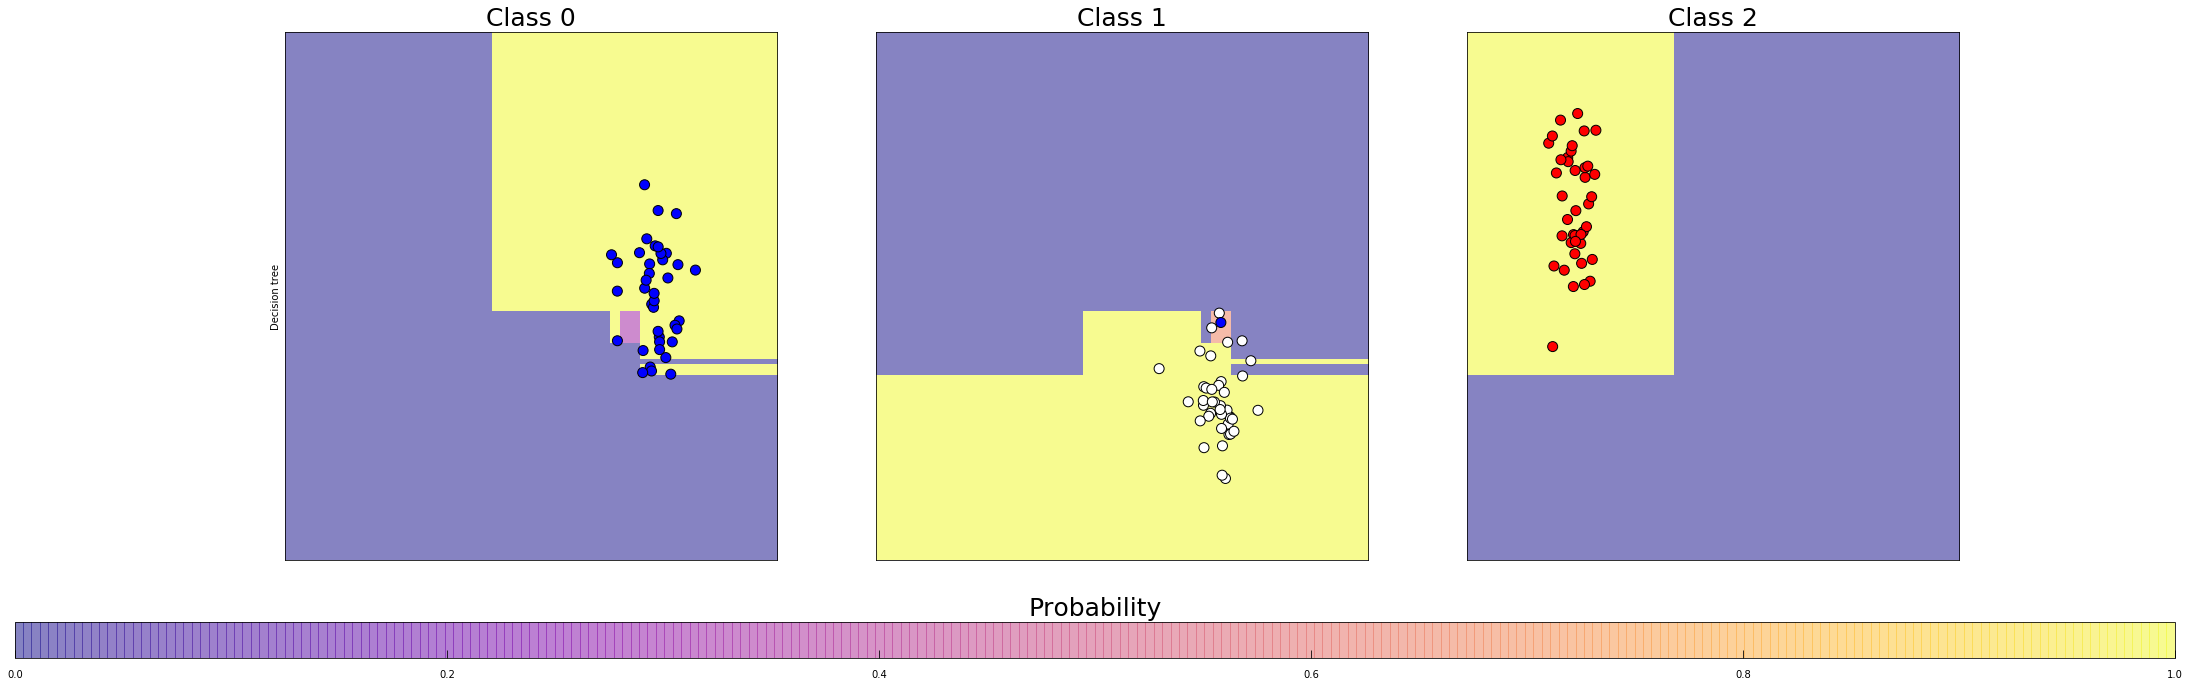

In [22]:
countour_RF(X_3, y_3,
            n_tree = 100, crit = 'gini', maxd = None,
            min_s = 4,
            min_l = 1, max_f = 'auto')
# We change min sample split from 2 to 4, that would be equivalent to add some regularization.

We added a little bit of regularization in the single tree and so we can start to see less sharp borders. For the random forest it changes a bit the countours.

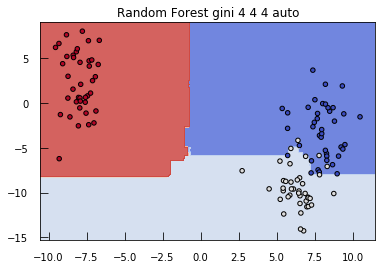

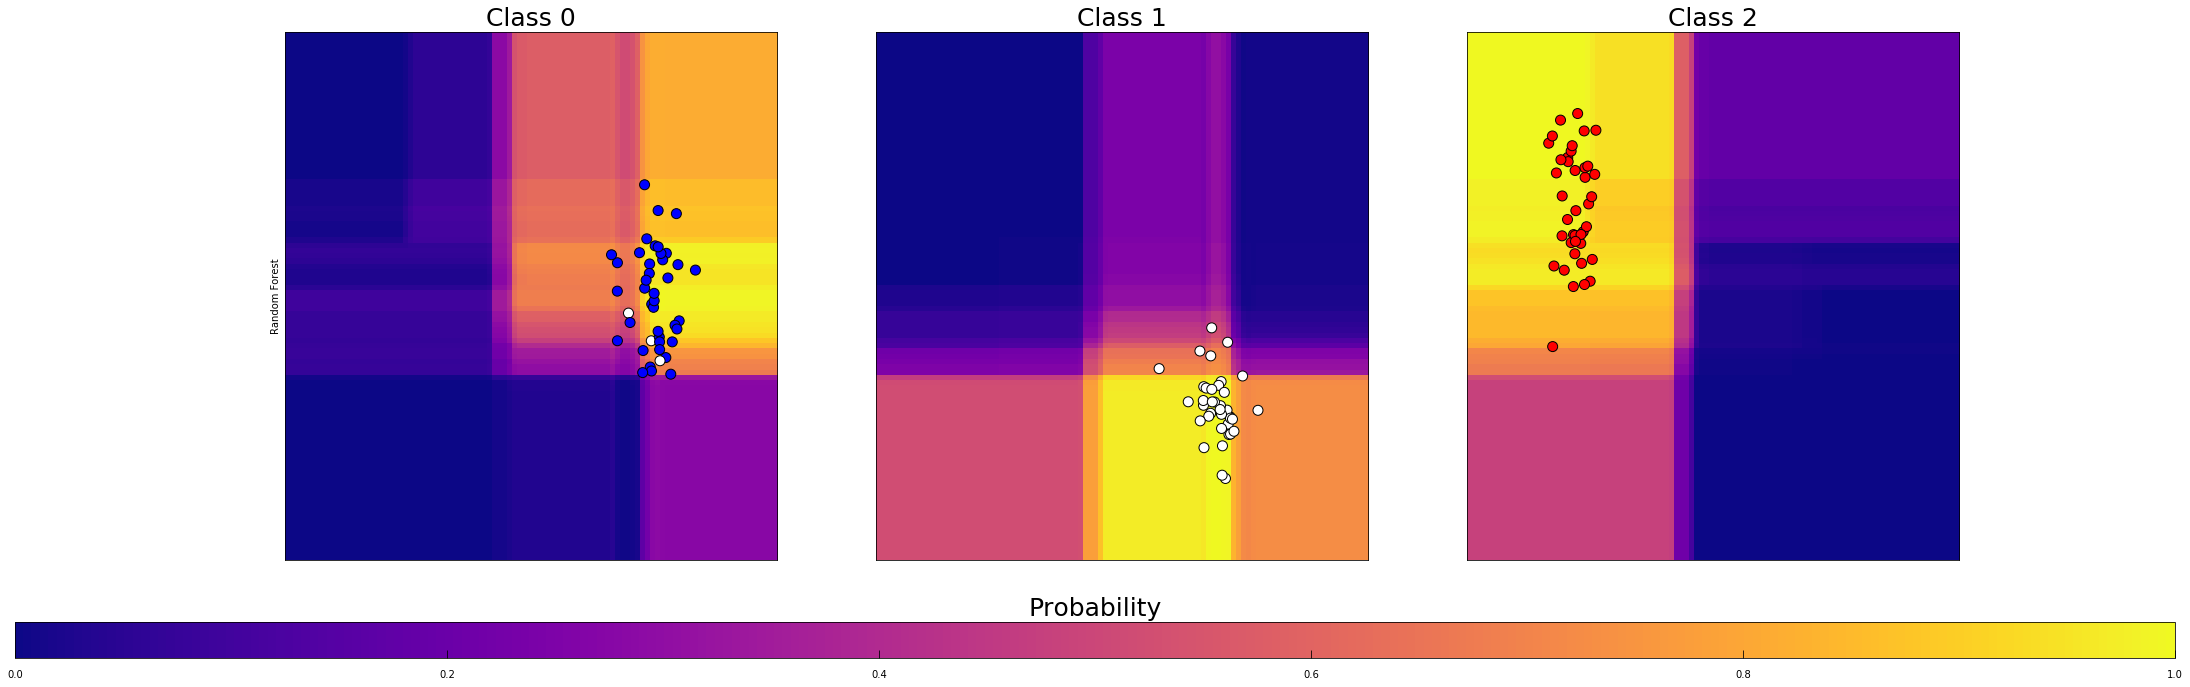

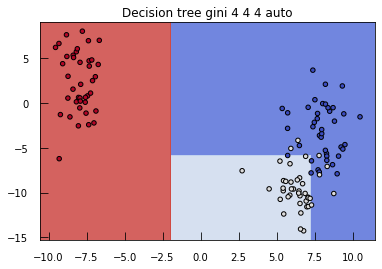

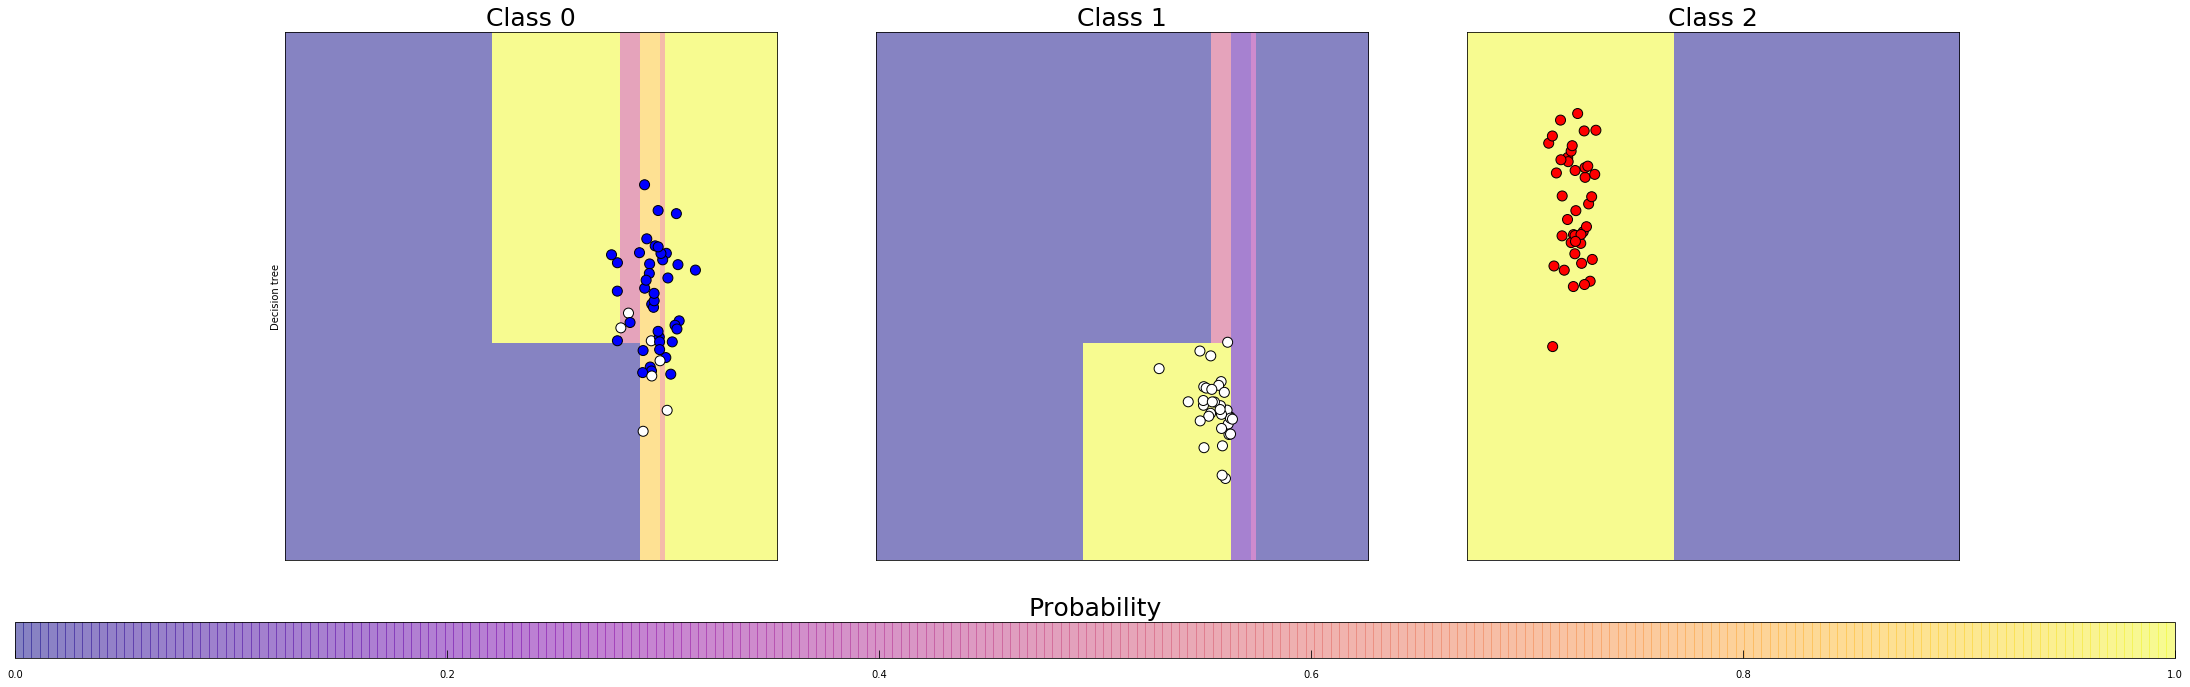

In [23]:
countour_RF(X_3, y_3,
            n_tree = 100, crit = 'gini',
            maxd = 4, 
            min_s = 4,
            min_l = 4,
            max_f = 'auto')
#Even more regularization, now we are more stringent on the size of the leaf and the 
#max depth of the individual trees

### Cancer data set

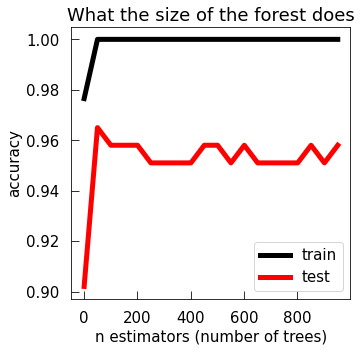

In [16]:
# testing a variety of number of trees
n_est=np.arange(1,1000,50) 
scores_test = []
scores_train = []

for k in n_est:
    tree = RandomForestClassifier(n_estimators = int(k),class_weight='balanced',n_jobs=-1)
    tree.fit(X_cancer_train,y_cancer_train)
    scores_test.append(tree.score(X_cancer_test, y_cancer_test))
    scores_train.append(tree.score(X_cancer_train, y_cancer_train))

# plotting
plt.figure()
plt.xlabel('n estimators (number of trees)')
plt.ylabel('accuracy')
plt.title('What the size of the forest does')
plt.plot(n_est, scores_train,'k-',linewidth=5,label='train')
plt.plot(n_est, scores_test,'r-',linewidth=5,label='test')
#plt.xticks([0,20,40,60,80,100])
plt.legend(loc='best')
plt.show()

Here 50 trees is probably a good guess as it is where test accuracy peaks without being insanely high for the train set.

In [17]:
from sklearn.metrics import confusion_matrix,accuracy_score


grid_values = {'criterion': ['entropy','gini'],
               'n_estimators':np.arange(1,500,100), 
               'max_depth':np.arange(2,int(len(X_cancer_train)/10),20),
               'min_samples_split':np.arange(2,int(len(X_cancer_train)/10),20),
              'min_samples_leaf':np.arange(1,int(len(X_cancer_train)/10),20)}# define the hyperparameters you want to test
#with the range over which you want it to be tested.

grid_tree_acc = GridSearchCV(RandomForestClassifier(n_jobs=-1,class_weight='balanced'), param_grid = grid_values, scoring='accuracy',n_jobs=-1)#Feed it to the GridSearchCV with the right
#score over which the decision should be taken

grid_tree_acc.fit(X_cancer_train, y_cancer_train)

y_decision_fn_scores_acc=grid_tree_acc.score(X_cancer_test,y_cancer_test)

print('Grid best parameter (max. accuracy): ', grid_tree_acc.best_params_)#get the best parameters
print('Grid best score (accuracy): ', grid_tree_acc.best_score_)#get the best score calculated from the train/validation
#dataset
print('Grid best parameter (max. accuracy) model on test: ', y_decision_fn_scores_acc)# get the equivalent score on the test
#dataset : again this is the important metric

y_pred_test_c=grid_tree_acc.predict(X_cancer_test)

confusion_mc_c = confusion_matrix(y_cancer_test, y_pred_test_c)
df_cm_c = pd.DataFrame(confusion_mc_c, 
                     index = [i for i in range(0,len(cancer['target_names']))], columns = [i for i in range(0,len(cancer['target_names']))])

Grid best parameter (max. accuracy):  {'criterion': 'entropy', 'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 101}
Grid best score (accuracy):  0.9624623803009575
Grid best parameter (max. accuracy) model on test:  0.958041958041958


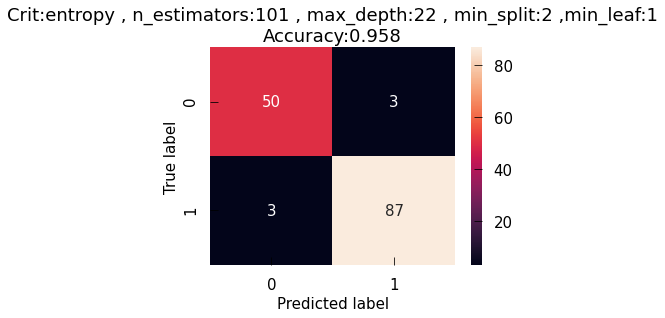

In [18]:
plt.figure(figsize=(5.5,4))
ax = sns.heatmap(df_cm_c, annot=True)
ax.set_ylim(2,0)
plt.title('Crit:'+str(grid_tree_acc.best_params_['criterion'])
          +' , n_estimators:'+str(grid_tree_acc.best_params_['n_estimators'])
          +' , max_depth:'+str(grid_tree_acc.best_params_['max_depth'])+' , min_split:'+str(grid_tree_acc.best_params_['min_samples_split'])+
          ' ,min_leaf:'+str(grid_tree_acc.best_params_['min_samples_leaf'])
          +'\nAccuracy:{0:.3f}'.format(accuracy_score(y_cancer_test, 
                                                                       y_pred_test_c)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [19]:
RF = RandomForestClassifier(criterion=grid_tree_acc.best_params_['criterion'],
                              n_estimators=grid_tree_acc.best_params_['n_estimators'],
                             max_depth=grid_tree_acc.best_params_['max_depth'],
                             min_samples_leaf=grid_tree_acc.best_params_['min_samples_leaf'],
                             min_samples_split=grid_tree_acc.best_params_['min_samples_split'],n_jobs=-1,class_weight='balanced')
RF.fit(X_cancer_train, y_cancer_train)
w=RF.feature_importances_#get the weights

sorted_features=sorted([[cancer['feature_names'][i],abs(w[i])] for i in range(len(w))],key=itemgetter(1),reverse=True)

print('Features sorted per importance in discriminative process')
soted_feature_df=pd.DataFrame(sorted_features,columns=['feature','abs contribution to the model'])
soted_feature_df

Features sorted per importance in discriminative process


,feature,abs contribution to the model
0,worst concave points,0.131775
1,worst radius,0.117521
2,worst perimeter,0.111331
3,mean concave points,0.099793
4,worst area,0.094448
5,mean concavity,0.065639
6,area error,0.050632
7,mean perimeter,0.042846
8,mean radius,0.036121
9,worst concavity,0.035991


# ADA Boost <a class="anchor" id="Ada-Boost"></a>

**This time again, you have a forest of trees, or rather, of stumps. ADA boost only consider the simplest type of trees : a single node with a yes or no question on one feature.** Unlike in random forest where all trees had the same power in the final decision, **in ADA boost stumps have different contributions in the final decision.** One last crucial difference between Random Forest and ADA boost is that in random forest each tree is created independently of each other whereas in **ADA boost there is an order and a logical reason that links two contiguous stumps.**

**In fact, each stump is made by taking the previous stumps mistakes into account and try to remedy to it.** How does it do that? By applying an importance weight on each sample. At the beginning of the algorithm all the samples have the same weight but then after the first stump, the missclassified points will have a higher weight so that the next stumps really focuses on predicting them well this time.

**The stumps have more to say in the classification if they have been better at classifying in general!** Funny thing (or not...) is that, if a specific stump has missclassified 100 % of the data it is actually a really good classifier if you decide to just reverse the labels.... What I am trying to say here is that the amount of vote credibility that a stump is given is not really how accurate it is but more how far from a random classifier it is, because again if you are 100% wrong it means that you have discovered a pattern but you misinterpreted it.

The actual voting weight for the stump $h_{t}$ is of the form $\alpha_{t}=L*log(\frac{1 - total.weigthed.error_{t}}{total.weigthed.error_{t}})$, where $L$ is the *learning rate*.

Since the different trees are not created in parallel like in random forest, and that you need to take into account errors from previous iterations, you now have to choose the strength of the bias for the next iteration (*ie.* how much does the new iteration can deviate from the previous one). 
This is similar to a learning rate in usual optimization problems. 
In Adaboost the error is put in an exponential (so the loss function is called exponential), which we try to  minimize at some rate called the *learning rate*. And so you guessed it, this is our new hyperparameter.

The actual update of the importance of indivudual points according to the errors of the stump at some iteration is following the the same formula as voting. Then, as explained before this error is put in an exponential and serves as the updated weights.

$w^{t+1}_{i}=w^{t}_{i}e^{\alpha_{t+1}}$ if $h_{t+1}$ made a mistake for point $i$

those weights are then normalized.

And at the end classification is made following a weighted average of the stumps:

$G(x)=\sum^{T}_{t=1}\alpha_{t}G_{t}(x)$


But rejoyce!! Since we are only using stumps we already got rid of all the other hyperparameters describing the tree topology (max depth, min samples split, min leaf split ).



![ADA](../images/ADA.png)

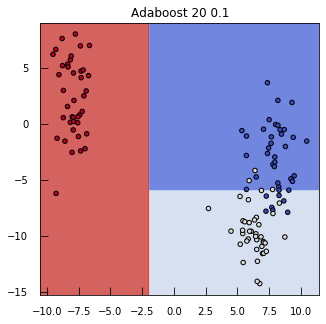

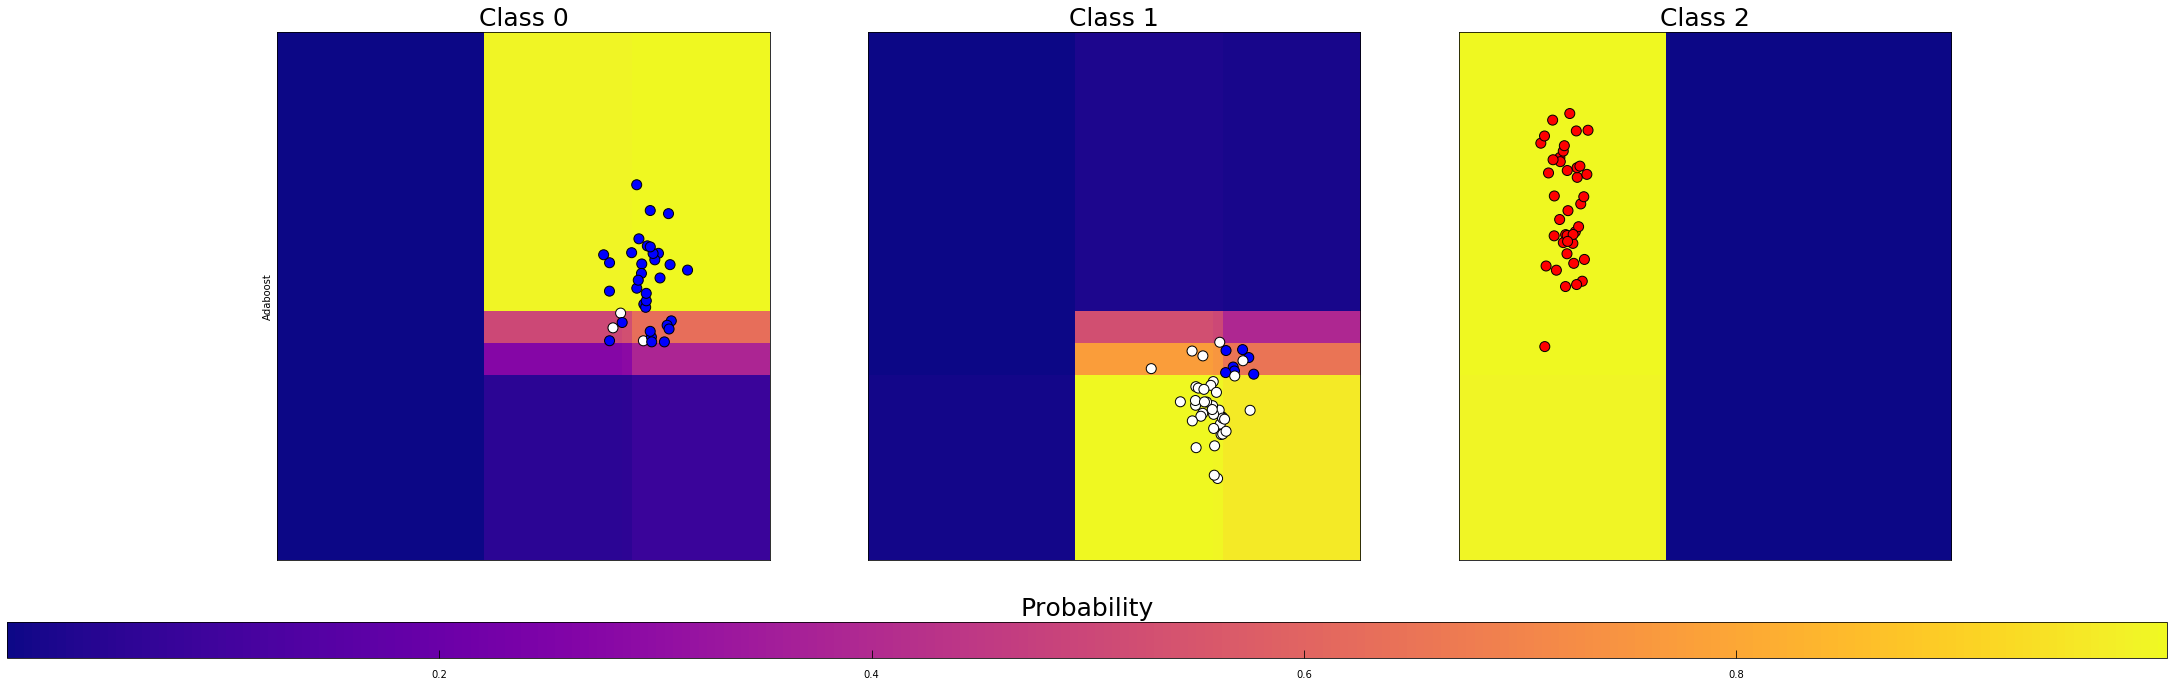

In [29]:
from utils import countour_ADA
countour_ADA(X_3, y_3,
             n_tree = 20 ,
             learn_r = 0.1) #20 stumps, learning rate is 0.1

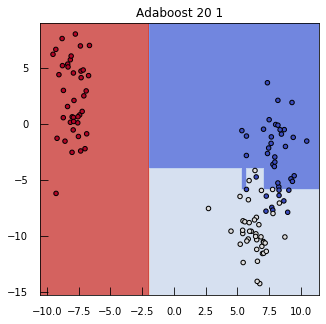

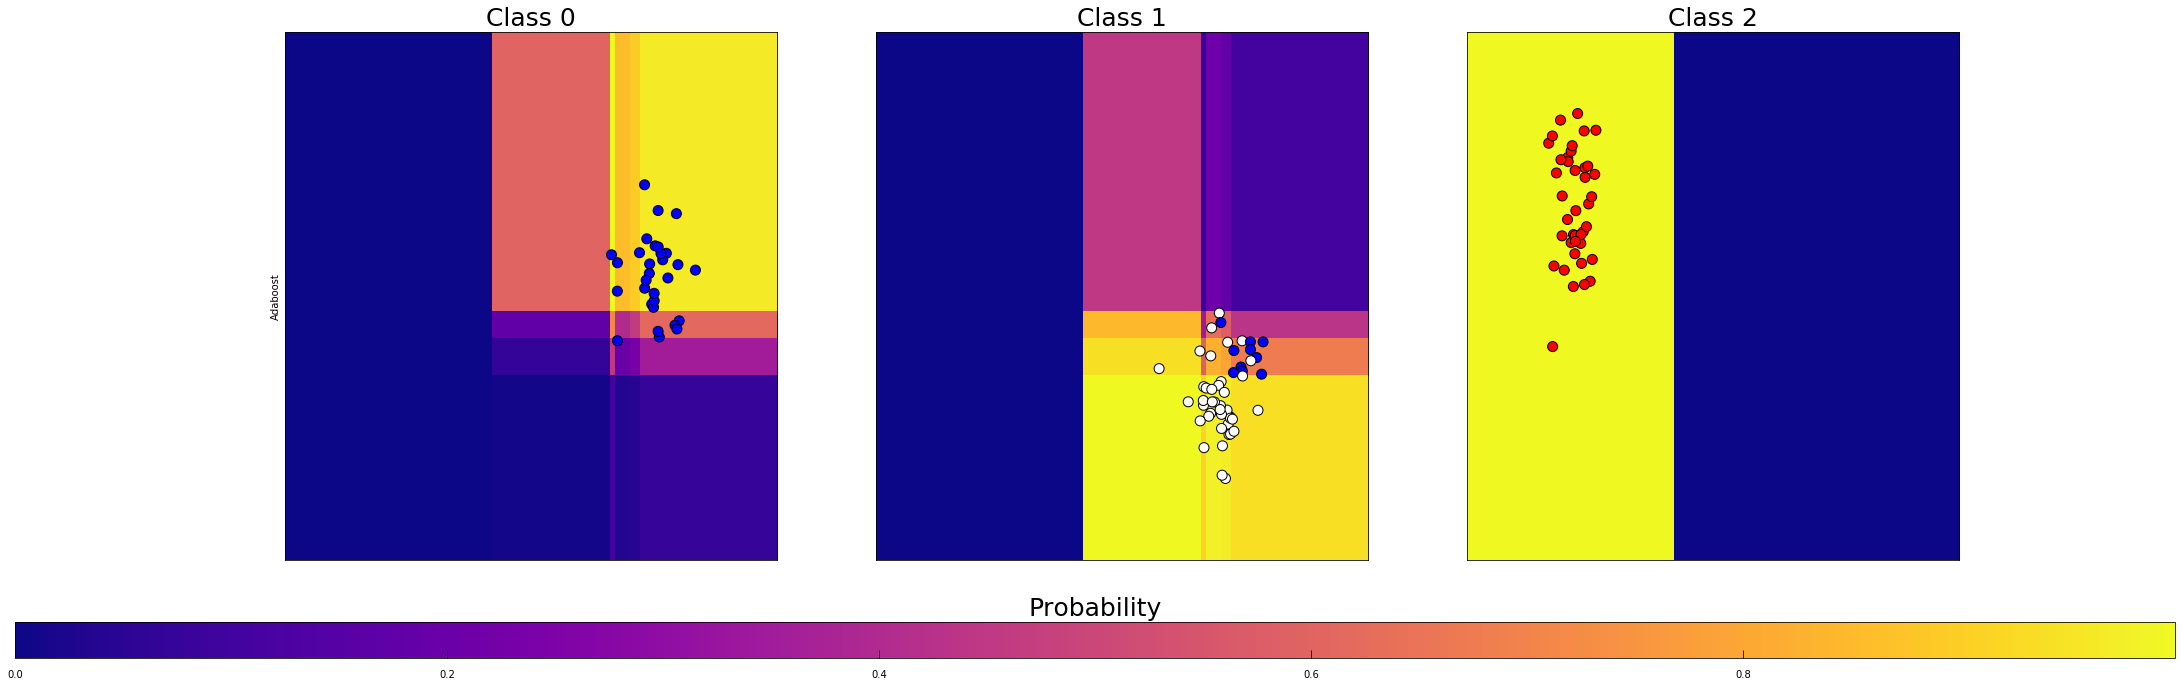

In [30]:
countour_ADA(X_3, y_3, 
             n_tree = 20, learn_r = 1)#learning rate is 1

### Cancer dataset

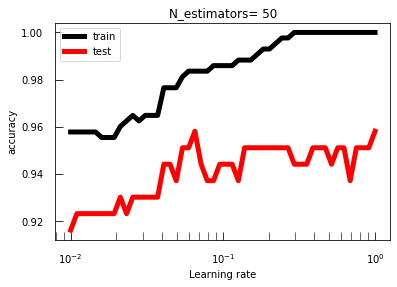

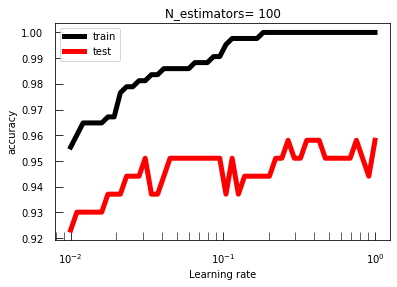

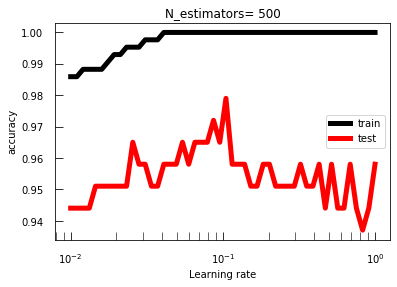

In [31]:
l_rate=np.logspace(-2,0,50) 

n_estimator=[50,100,500]
for j in n_estimator:
    scores_test = []
    scores_train = []
    for k in l_rate:
        tree = AdaBoostClassifier(n_estimators=j,learning_rate=k)
        tree.fit(X_cancer_train,y_cancer_train)
        scores_test.append(tree.score(X_cancer_test, y_cancer_test))
        scores_train.append(tree.score(X_cancer_train, y_cancer_train))

    plt.figure()
    plt.xlabel('Learning rate')
    plt.ylabel('accuracy')
    plt.xscale('log')
    plt.title('N_estimators= '+str(j))
    plt.plot(l_rate, scores_train,'k-',linewidth=5,label='train')
    plt.plot(l_rate, scores_test,'r-',linewidth=5,label='test')
    plt.legend(loc='best')
    plt.show()

The two hyperparameters number of of stumps and learning rate are actually interdependent. The law associating the two is not obvious but just keep in mind that if the number of stumps is large you don't need a big learning rate.

In [32]:
from sklearn.metrics import confusion_matrix,accuracy_score
#DecisionTreeClassifier(criterion=crit,max_depth=maxd,min_samples_split=min_s,min_samples_leaf=min_l)

grid_values = {'n_estimators':np.arange(1,1000,50), 
               'learning_rate':np.arange(0.01,0.1,0.01)
               }# define the hyperparameters you want to test
#with the range over which you want it to be tested.

grid_tree_acc = GridSearchCV(AdaBoostClassifier(), param_grid = grid_values, scoring='accuracy',n_jobs=-1)#Feed it to the GridSearchCV with the right
#score over which the decision should be taken

grid_tree_acc.fit(X_cancer_train, y_cancer_train)

y_decision_fn_scores_acc=grid_tree_acc.score(X_cancer_test,y_cancer_test)

print('Grid best parameter (max. accuracy): ', grid_tree_acc.best_params_)#get the best parameters
print('Grid best score (accuracy): ', grid_tree_acc.best_score_)#get the best score calculated from the train/validation
#dataset
print('Grid best parameter (max. accuracy) model on test: ', y_decision_fn_scores_acc)# get the equivalent score on the test
#dataset : again this is the important metric

y_pred_test_c=grid_tree_acc.predict(X_cancer_test)

confusion_mc_c = confusion_matrix(y_cancer_test, y_pred_test_c)
df_cm_c = pd.DataFrame(confusion_mc_c, 
                     index = [i for i in range(0,len(cancer['target_names']))], columns = [i for i in range(0,len(cancer['target_names']))])

/home/wandrille/Installed_software/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Grid best parameter (max. accuracy):  {'learning_rate': 0.03, 'n_estimators': 501}
Grid best score (accuracy):  0.9694835680751174
Grid best parameter (max. accuracy) model on test:  0.965034965034965


Text(0.5, 10.0, 'Predicted label')

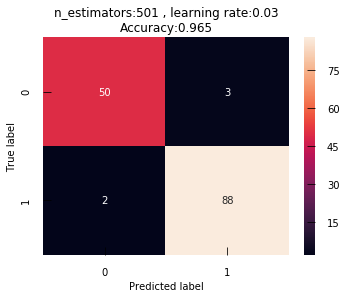

In [33]:
plt.figure(figsize=(5.5,4))
ax = sns.heatmap(df_cm_c, annot=True)
ax.set_ylim(2,0)
plt.title('n_estimators:'+str(grid_tree_acc.best_params_['n_estimators'])
          +' , learning rate:'+str(grid_tree_acc.best_params_['learning_rate'])
          +'\nAccuracy:{0:.3f}'.format(accuracy_score(y_cancer_test, 
                                                                       y_pred_test_c)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Boosted gradient <a class="anchor" id="Boosted-Gradient"></a>

As you can already imagine from the name in the case of boosted gradient the optimization of our algorithm follow the gradient of a loss function (or of a maximum likelihood!).

Just like ADAboost and random forest, boosted gradient **creates many trees** and datasets toward making its decision. In oposition to ADAboost the next tree, which is not limited to a stomp,  is fitted on the error from the previous and not on a dataset inflating the effect of previous error. At the end you still have a quorum of tree for which the voting is done proportionally to the gradient value.

![boosted](../images/boosted.png)

So what gradient are we talking about? Of course the gradient of a loss function. This loss function is quite different from the one used in AdaBoost. To understand it, we have to realize that the only thing boosted gradient does (when used for classification), **is to transform the leaves scores of its trees into log odds ratios! Basically, it is switching gear between a loss function that aims at differentiating between class, toward a loss function that tries to fit a function (regression)**. 
It is a smart way to do highly non linear classification rules, based on logistic regression!!!!! 
It then follows the gradient of feature combinations (tree) that minimize the difference between the predicted log odds and its labeled values (1 or 0).

We will see later that regression gradient boost does the same : follow the combinations of features (tree) and minimize the error of the function outcome prediction to the real value.

It might seems a little artifical to do so because here we need one more step to transform a problem of classification (which the algo has not really been optimized for) to a regression problem... 

> That consideration could be reversed on if we use algo obviously suitable for classification in the context of regression... (see extra chapter on machine learning and regression).


**In term of hyperparameters it is a concatenation of all that we have seen before : 
the hyperparameters needed to describe a decision tree, a number of iteration and a learning rate.** 

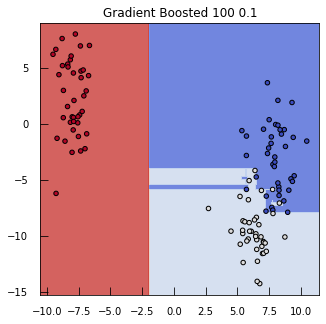

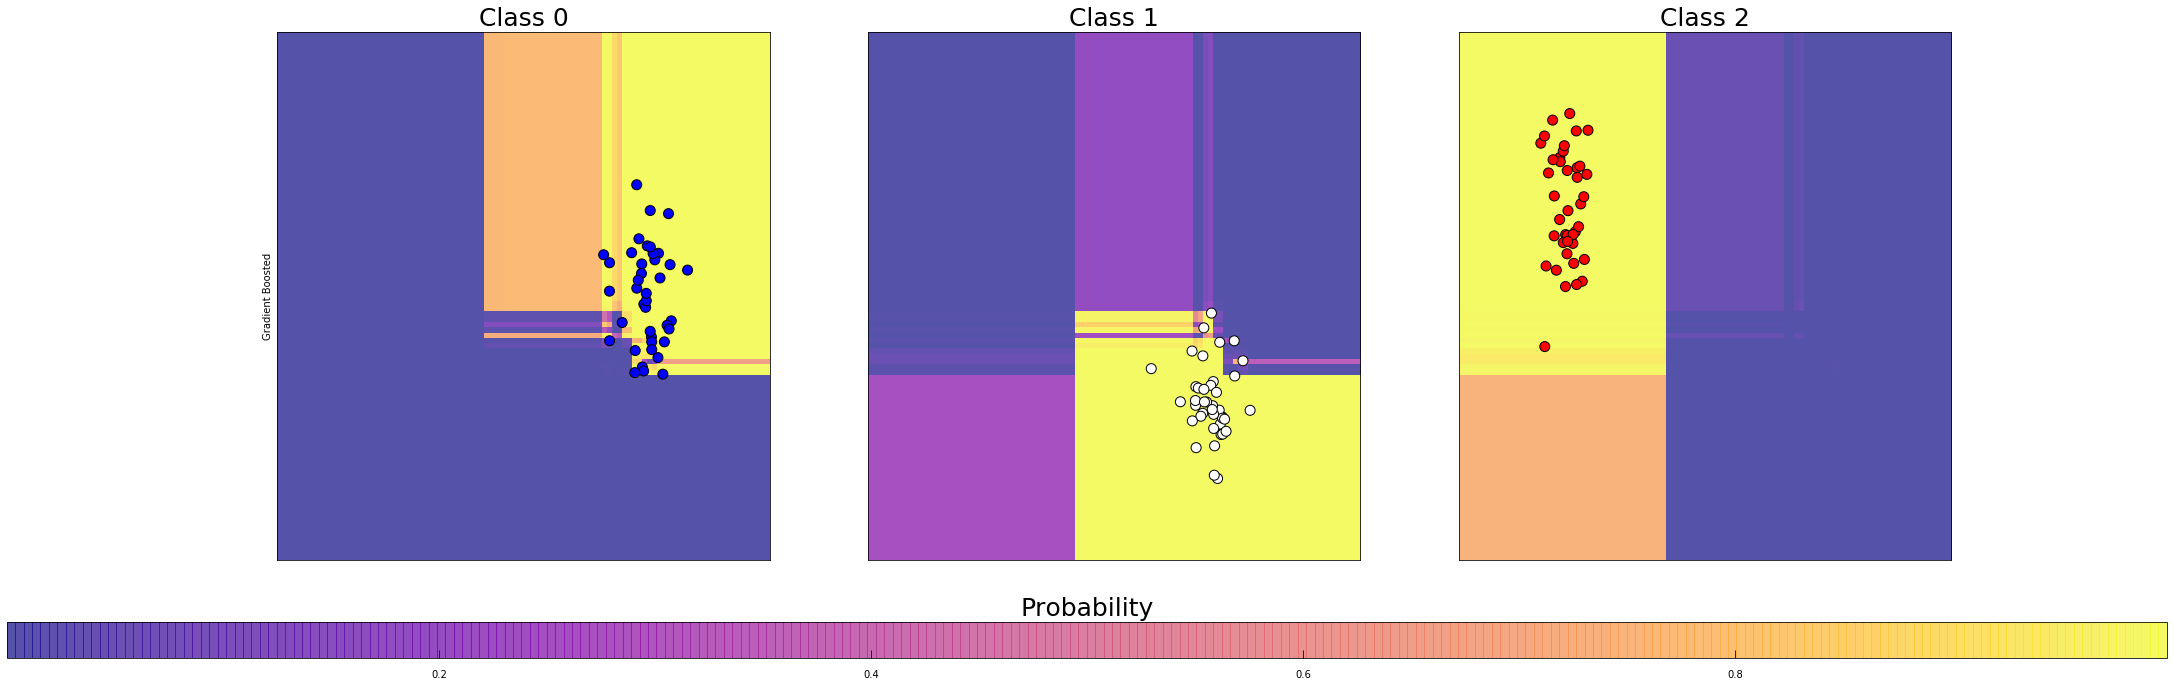

In [34]:
from utils import countour_BG
countour_BG(X_3, y_3,
            n_tree = 100,
            learn_r = 0.1,
            max_d = 4,
            min_s = 2,
            min_l = 2,
            max_f = 'auto')

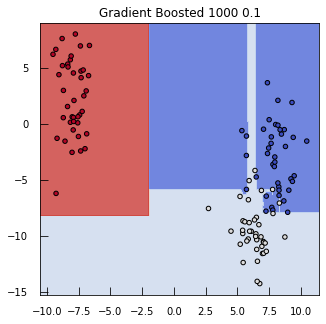

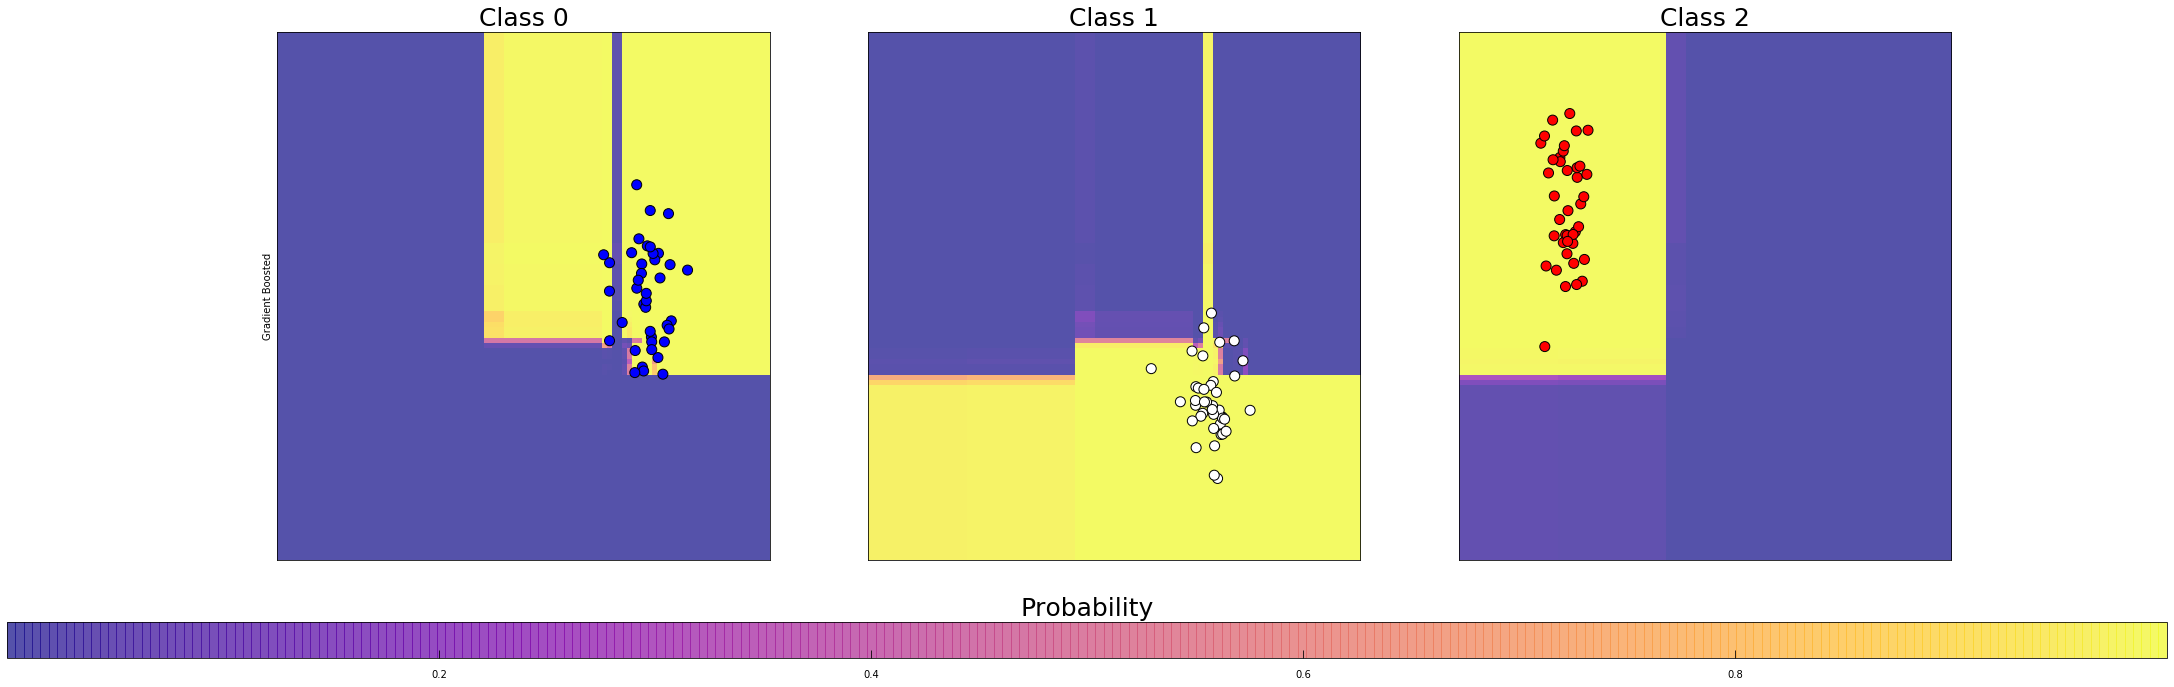

In [35]:
countour_BG(X_3, y_3,
            n_tree = 1000,
            learn_r = 0.1,
            max_d = 4,
            min_s = 2,
            min_l = 10,
            max_f = 'auto')

In [36]:
grid_values = {'learning_rate':np.arange(0.01,0.1,0.01),
                'n_estimators':np.arange(1,500,100), 
               'max_depth':np.arange(2,int(len(X_cancer_train)/10),20),
               'min_samples_split':np.arange(2,int(len(X_cancer_train)/10),20),
              'min_samples_leaf':np.arange(1,int(len(X_cancer_train)/10),20)}# define the hyperparameters you want to test
#with the range over which you want it to be tested.

grid_tree_acc = GridSearchCV(GradientBoostingClassifier(), param_grid = grid_values, scoring='accuracy',n_jobs=-1)#Feed it to the GridSearchCV with the right
#score over which the decision should be taken

grid_tree_acc.fit(X_cancer_train, y_cancer_train)

y_decision_fn_scores_acc=grid_tree_acc.score(X_cancer_test,y_cancer_test)

print('Grid best parameter (max. accuracy): ', grid_tree_acc.best_params_)#get the best parameters
print('Grid best score (accuracy): ', grid_tree_acc.best_score_)#get the best score calculated from the train/validation
#dataset
print('Grid best parameter (max. accuracy) model on test: ', y_decision_fn_scores_acc)# get the equivalent score on the test
#dataset : again this is the important metric

y_pred_test_c=grid_tree_acc.predict(X_cancer_test)

confusion_mc_c = confusion_matrix(y_cancer_test, y_pred_test_c)
df_cm_c = pd.DataFrame(confusion_mc_c, 
                     index = [i for i in range(0,len(cancer['target_names']))], columns = [i for i in range(0,len(cancer['target_names']))])

/home/wandrille/Installed_software/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Grid best parameter (max. accuracy):  {'learning_rate': 0.05, 'max_depth': 2, 'min_samples_leaf': 41, 'min_samples_split': 22, 'n_estimators': 201}
Grid best score (accuracy):  0.971830985915493
Grid best parameter (max. accuracy) model on test:  0.958041958041958


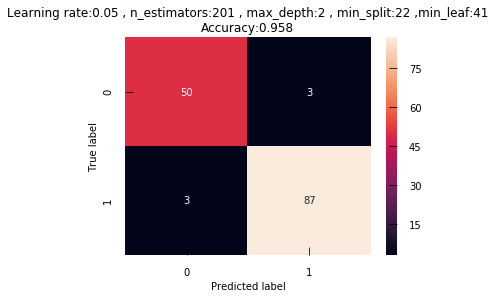

In [38]:
plt.figure(figsize=(5.5,4))
ax = sns.heatmap(df_cm_c, annot=True)
ax.set_ylim(2,0)
plt.title('Learning rate:'+str(grid_tree_acc.best_params_['learning_rate'])
          +' , n_estimators:'+str(grid_tree_acc.best_params_['n_estimators'])
          +' , max_depth:'+str(grid_tree_acc.best_params_['max_depth'])+' , min_split:'+str(grid_tree_acc.best_params_['min_samples_split'])+
          ' ,min_leaf:'+str(grid_tree_acc.best_params_['min_samples_leaf'])
          +'\nAccuracy:{0:.3f}'.format(accuracy_score(y_cancer_test, 
                                                                       y_pred_test_c)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [39]:
BG = GradientBoostingClassifier(learning_rate=grid_tree_acc.best_params_['learning_rate'],
                              n_estimators=grid_tree_acc.best_params_['n_estimators'],
                             max_depth=grid_tree_acc.best_params_['max_depth'],
                             min_samples_leaf=grid_tree_acc.best_params_['min_samples_leaf'],
                             min_samples_split=grid_tree_acc.best_params_['min_samples_split'])
BG.fit(X_cancer_train, y_cancer_train)
w=BG.feature_importances_#get the weights

sorted_features=sorted([[cancer['feature_names'][i],abs(w[i])] for i in range(len(w))],key=itemgetter(1),reverse=True)

print('Features sorted per importance in discriminative process')
soted_feature_df=pd.DataFrame(sorted_features,columns=['feature','abs contribution to the model'])
soted_feature_df

Features sorted per importance in discriminative process


,feature,abs contribution to the model
0,worst perimeter,0.328423
1,worst concave points,0.248185
2,mean concave points,0.183540
3,worst radius,0.124681
4,worst texture,0.035256
5,worst area,0.030164
6,area error,0.018042
7,worst concavity,0.013947
8,mean texture,0.004756
9,worst symmetry,0.002841


# Exercice : <a class="anchor" id="exo"></a>


The automobile data set (`data/Automobile_data.csv`) records 

There is a bit of preprocessing to do first :

In [64]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/Automobile_data.csv')

# accounting for NAs, with some imputation
df.replace("?", np.nan, inplace = True)

avg_norm_loss = df["normalized-losses"].astype("float").mean(axis=0)
df["normalized-losses"].replace(np.nan, avg_norm_loss, inplace=True)

avg_bore=df['bore'].astype('float').mean(axis=0)
df["bore"].replace(np.nan, avg_bore, inplace=True)

avg_stroke=df['stroke'].astype('float').mean(axis=0)
df["stroke"].replace(np.nan, avg_stroke, inplace=True)

avg_horsepower = df['horsepower'].astype('float').mean(axis=0)
df['horsepower'].replace(np.nan, avg_horsepower, inplace=True)

avg_price = df['price'].astype('float').mean(axis=0)
df['price'].replace(np.nan, avg_price, inplace=True)

avg_peakrpm=df['peak-rpm'].astype('float').mean(axis=0)
df['peak-rpm'].replace(np.nan, avg_peakrpm, inplace=True)

#like replacing by the max used for example
print(df['num-of-doors'].value_counts())
print(df['num-of-doors'].value_counts().idxmax())

df["num-of-doors"].replace(np.nan, "four", inplace=True)

#If your interested in lines rather than columns you can drop lines (index) for which a certaine feature is NAN.
df.dropna(subset=["price"], axis=0, inplace=True)

df.reset_index(drop=True, inplace=True)

df["horsepower"]=df["horsepower"].astype(int, copy=True)

df[["bore", "stroke"]] = df[["bore", "stroke"]].astype("float")
df[["normalized-losses"]] = df[["normalized-losses"]].astype("int")
df[["price"]] = df[["price"]].astype("float")
df[["peak-rpm"]] = df[["peak-rpm"]].astype("float")


four    114
two      89
Name: num-of-doors, dtype: int64
four


In [65]:
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,122,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000.0,21,27,13495.0
1,3,122,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000.0,21,27,16500.0
2,1,122,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000.0,19,26,16500.0
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500.0,24,30,13950.0
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500.0,18,22,17450.0


(array([81., 45., 39., 17.,  6.,  3.,  4.,  7.,  2.,  1.]),
 array([ 5118. ,  9146.2, 13174.4, 17202.6, 21230.8, 25259. , 29287.2,
        33315.4, 37343.6, 41371.8, 45400. ]),
 <a list of 10 Patch objects>)

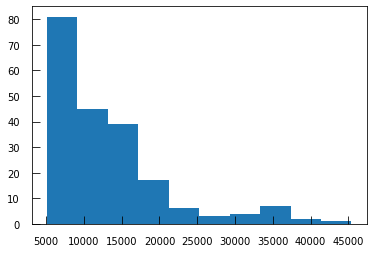

In [66]:
plt.hist(df.price)

**Your goal is to try to predict what makes a car expensive, mediumly costly or "cheap". Focus on decision tree like models.**

Of course, you will have to first **change your numerical price by binning them into categories** like : low, medium, high. Give it a number associated to the classes low, medium, high, instead of those names : algo sometimes don't like to work with categorical variables...

What are the main features predictive of a class of prices? What do you think of the reliability of your model??

> Hint: the decision_function that we used for the other algo is called predict_proba for decision tree like models

> Note : if you use models more complex than a simple decision tree (and you should) you will have to change categorical data to numerical one.

# One possible correction 

Uncomment and run these to load the different parts of the correcton

In [ ]:
# %load -r 1-25 chapter03_exercice_corr.py

## first we bin prices, and get rid of the original price column

bins = np.quantile(df.price, [0,1/3.,2/3.,1])
group_names = ['Low', 'Medium', 'High']

df['price_binned'] = pd.cut(df['price'], bins, labels=group_names, include_lowest=True )
df.drop('price',axis = 1, inplace=True)

## separating target and coVariables 
X = df.drop( columns='price_binned' ) # notice the lack of in-place
y = df.price_binned

print(y.value_counts())

## transforming categorical variables 
X = pd.get_dummies(X)



## splitting in train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  random_state=0)

In [ ]:
# %load -r 26-45 chapter03_exercice_corr.py

grid_values = {'learning_rate':np.arange(0.01,0.1,0.01),
                'n_estimators':np.arange(1,500,100), 
               'max_depth':np.arange(2,int(len(X_train)),20),
               'min_samples_split':np.arange(2,int(len(X_train)/10),20),
              'min_samples_leaf':np.arange(1,int(len(X_train)/10),20)}# define the hyperparameters you want to test
#with the range over which you want it to be tested.

grid_tree_acc = GridSearchCV(GradientBoostingClassifier(), param_grid = grid_values, scoring='accuracy')#Feed it to the GridSearchCV with the right
#score over which the decision should be taken

grid_tree_acc.fit(X_train, np.array(y_train).ravel())

y_decision_fn_scores_acc=grid_tree_acc.score(X_test,np.array(y_test).ravel())

print('Grid best parameter (max. accuracy): ', grid_tree_acc.best_params_)#get the best parameters
print('Grid best score (accuracy): ', grid_tree_acc.best_score_)#get the best score calculated from the train/validation
#dataset
print('Grid best parameter (max. accuracy) model on test: ', y_decision_fn_scores_acc)# get the equivalent score on the test
#dataset : again this is the important metric

In [ ]:
# %load -r 46-63 chapter03_exercice_corr.py

y_pred_test_c=grid_tree_acc.predict(X_test)

confusion_mc_c = confusion_matrix(y_test, y_pred_test_c)
df_cm_c = pd.DataFrame(confusion_mc_c, 
                     index = ['Low', 'Medium', 'High'], columns = ['Low', 'Medium', 'High'])

plt.figure(figsize=(5.5,4))
sns.heatmap(df_cm_c, annot=True)
plt.title('Learning rate:'+str(grid_tree_acc.best_params_['learning_rate'])
          +' , n_estimators:'+str(grid_tree_acc.best_params_['n_estimators'])
          +' , max_depth:'+str(grid_tree_acc.best_params_['max_depth'])+' , min_split:'+str(grid_tree_acc.best_params_['min_samples_split'])+
          ' ,min_leaf:'+str(grid_tree_acc.best_params_['min_samples_leaf'])
          +'\nAccuracy:{0:.3f}'.format(accuracy_score(y_test, 
                                                                       y_pred_test_c)))
plt.ylim(3,0)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
# %load -r 64- chapter03_exercice_corr.py
from operator import itemgetter
RFC = GradientBoostingClassifier(learning_rate=grid_tree_acc.best_params_['learning_rate'],
                            n_estimators=grid_tree_acc.best_params_['n_estimators'],
                            max_depth=grid_tree_acc.best_params_['max_depth'],
                            min_samples_split=grid_tree_acc.best_params_['min_samples_split'],
                           min_samples_leaf=grid_tree_acc.best_params_['min_samples_leaf'])
RFC.fit(X_train, np.array(y_train).ravel())
w=RFC.feature_importances_#get the weights

sorted_features=sorted([[X.columns[i],abs(w[i])] for i in range(len(w))],key=itemgetter(1),reverse=True)

print('Features sorted per importance in discriminative process (up to 99% of cumulated weight)')
s = 0
for f,w in sorted_features:
    print(f.rjust(25), '{:.4f}'.format(w) , sep='\t')
    s += w
    if s> 0.99:
        break
